## 1.데이터 불러오기

In [2]:
!pip install optuna
!pip install catboost

     -------------------------------------- 364.4/364.4 kB 7.5 MB/s eta 0:00:00
     -------------------------------------- 233.5/233.5 kB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 78.6/78.6 kB ? eta 0:00:00


In [3]:
# 필수 라이브러리
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from collections import Counter
from scipy.stats import ttest_ind, spearmanr, pearsonr

# 모델 관련 라이브러리
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    r2_score,
    accuracy_score,
    mean_squared_log_error,
    precision_recall_curve,
    auc
)
from sklearn.feature_selection import SelectFromModel
from imblearn.combine import SMOTEENN

# Boosting 모델 라이브러리
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Hyperparameter Optimization
import optuna

# 한글 그래프를 위한 설정
!pip install koreanize-matplotlib
import koreanize_matplotlib

     ---------------------------------------- 7.9/7.9 MB 10.6 MB/s eta 0:00:00


In [4]:
pd.options.mode.chained_assignment = None # 경고 메시지 중 SettingWithCopyWarning을 방지
warnings.filterwarnings("ignore", category=DeprecationWarning) # 불필요한 경고 메시지를 무시
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [5]:
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [32]:
site_area = pd.read_csv("data/site_area.csv")
trial_access_log = pd.read_csv("data/trial_access_log.csv")
trial_payment = pd.read_csv("data/trial_payment.csv")
trial_register = pd.read_csv("data/trial_register.csv")
trial_visit_info = pd.read_csv("data/trial_visit_info.csv")

## 2.데이터 전처리

### 2-1. 중복값 제거

In [33]:
trial_register_cleaned = (
    trial_register.sort_values(by=['user_uuid', 'trial_date'], ascending=[True, False])
    .drop_duplicates(subset=['user_uuid'], keep='first')
)
trial_access_log_cleaned = trial_access_log.drop_duplicates(subset=['id'], keep='first')
trial_payment_cleaned = trial_payment.drop_duplicates(subset=['user_uuid'], keep='first')
site_area_cleaned = site_area.drop_duplicates(subset=['site_id'], keep='first')

### 2-2. 결측치 처리

In [34]:
# 결측치 확인
missing_values = {
    "trial_register_cleaned": trial_register_cleaned.isnull().sum(),
    "trial_access_log_cleaned": trial_access_log_cleaned.isnull().sum(),
    "trial_payment_cleaned": trial_payment_cleaned.isnull().sum(),
    "site_area_cleaned": site_area_cleaned.isnull().sum(),
}
missing_values

{'trial_register_cleaned': trial_date    0
 user_uuid     0
 dtype: int64,
 'trial_access_log_cleaned': id           0
 checkin      0
 cdate        0
 site_id      0
 user_uuid    0
 dtype: int64,
 'trial_payment_cleaned': is_payment    0
 user_uuid     0
 dtype: int64,
 'site_area_cleaned': site_id        0
 area_pyeong    0
 dtype: int64}

### 2-3. 이상치 처리

- **TRIAL_ACCESS_LOG 테이블**
    1. cdate 마이크로초 제거 및 +9시간 추가(trial_visit_info 테이블의 시간이 KST이므로 9시간 차이나는 것을 확인후 변환하였음)
    2. 비정상 체크인 검토 → 총 2,153개 행 감소
        - 입실과 퇴실 갯수가 일치하지 않는 유저 : 1,762명
        - 입실(1)로 시작하지 않거나 퇴실(2)로 끝나지 않는 유저 : 403명
            - 1초간격으로 입실 혹은 퇴실 정보를 추가 (414건)
        - 입실 또는 퇴실이 2번 이상 연속으로 나오는 경우 : 1,682명
            - 입실(1)이 연속이면 마지막 데이터만 유지(앞단 입실 정보는 퇴실정보가 사라졌으므로 정확한 측정 불가)
            - 퇴실(2)이 연속이면 첫번째 데이터만 유지(뒷단 퇴실 정보는 입실정보가 사라졌으므로 정확한 측정 불가)
            - 2,567건 제거

In [35]:
# 마이크로초 제거 후 9시간 추가
trial_access_log_cleaned['cdate'] = pd.to_datetime(trial_access_log_cleaned['cdate'], errors='coerce').dt.floor('S') + timedelta(hours=9)

In [36]:
# trial_access_log_cleaned를 user_uuid와 cdate 기준으로 정렬
access_log_sorted_asc = trial_access_log_cleaned.sort_values(by=['user_uuid', 'cdate'], ascending=[True, True])

# 체크인 데이터의 이상 패턴 확인
# 각 사용자에 대해 '1'(체크인)과 '2'(체크아웃)의 개수가 같지 않은지 확인
unequal_checkin_checkout = access_log_sorted_asc.groupby('user_uuid')['checkin'].apply(
    lambda x: Counter(x)[1] != Counter(x)[2]
)

# 사용자의 시퀀스가 '1'(체크인)으로 시작하지 않거나 '2'(체크아웃)으로 끝나지 않는지 확인
invalid_start_end = access_log_sorted_asc.groupby('user_uuid')['checkin'].apply(
    lambda x: x.iloc[0] != 1 or x.iloc[-1] != 2
)

# 연속된 이상값을 방지하기 위해 KeyError를 피하도록 재계산
def has_consecutive_abnormalities_fixed(checkin_sequence):
    checkin_sequence = list(checkin_sequence)  # 리스트 형식으로 변환하여 올바른 인덱싱 보장
    for i in range(1, len(checkin_sequence)):
        if checkin_sequence[i] == checkin_sequence[i - 1]:  # 이전 값과 동일한 연속된 값 확인
            return True
    return False

# 연속된 이상값에 대한 수정된 함수 적용
consecutive_abnormalities_fixed = access_log_sorted_asc.groupby('user_uuid')['checkin'].apply(has_consecutive_abnormalities_fixed)

# 모든 이상값 확인을 다시 결합
abnormal_users_fixed = unequal_checkin_checkout | invalid_start_end | consecutive_abnormalities_fixed

# 이상 사용자의 행 추출
abnormal_data_fixed = access_log_sorted_asc[access_log_sorted_asc['user_uuid'].isin(abnormal_users_fixed[abnormal_users_fixed].index)]

# 이상 데이터의 첫 몇 개의 행과 이상값 요약 표시
abnormal_data_fixed.head(), {
    "unequal_checkin_checkout_count": unequal_checkin_checkout.sum(),
    "invalid_start_end_count": invalid_start_end.sum(),
    "consecutive_abnormalities_count": consecutive_abnormalities_fixed.sum()
}

(            id  checkin               cdate  site_id  \
 47415  2072533        1 2023-11-15 09:44:08        6   
 47401  2073606        2 2023-11-15 13:47:23        6   
 47414  2073607        1 2023-11-15 13:47:41        6   
 47407  2073767        1 2023-11-15 14:18:15        6   
 47404  2073772        2 2023-11-15 14:19:05        6   
 
                                   user_uuid  
 47415  0018e22d-a2cc-4e06-bca2-d6a041770f3b  
 47401  0018e22d-a2cc-4e06-bca2-d6a041770f3b  
 47414  0018e22d-a2cc-4e06-bca2-d6a041770f3b  
 47407  0018e22d-a2cc-4e06-bca2-d6a041770f3b  
 47404  0018e22d-a2cc-4e06-bca2-d6a041770f3b  ,
 {'unequal_checkin_checkout_count': 1762,
  'invalid_start_end_count': 403,
  'consecutive_abnormalities_count': 1682})

In [37]:
# 2번째 규칙 적용: 잘못된 시작 또는 끝 항목을 추가하여 수정
def fix_start_end_with_1sec(group):
    if group.iloc[0]['checkin'] != 1:  # '1'(체크인)으로 시작하지 않으면 추가
        first_row = group.iloc[0].copy()
        first_row['checkin'] = 1
        first_row['cdate'] -= pd.Timedelta(seconds=1)  # 1초 이전의 항목 추가
        group = pd.concat([pd.DataFrame([first_row]), group])
    if group.iloc[-1]['checkin'] != 2:  # '2'(체크아웃)으로 끝나지 않으면 추가
        last_row = group.iloc[-1].copy()
        last_row['checkin'] = 2
        last_row['cdate'] += pd.Timedelta(seconds=1)  # 1초 이후의 항목 추가
        group = pd.concat([group, pd.DataFrame([last_row])])
    return group.sort_values('cdate')

fixed_start_end = access_log_sorted_asc.groupby('user_uuid').apply(fix_start_end_with_1sec).reset_index(drop=True)

# 3번째 규칙 적용: 연속된 중복 처리
def handle_consecutive_duplicates_custom(group):
    result = []
    for key, sub_group in group.groupby((group['checkin'] != group['checkin'].shift()).cumsum()):
        if len(sub_group) > 1:  # 중복이 있는 경우
            if sub_group.iloc[0]['checkin'] == 1:  # '1'(체크인)인 경우 마지막 항목 유지
                result.append(sub_group.iloc[-1])
            elif sub_group.iloc[0]['checkin'] == 2:  # '2'(체크아웃)인 경우 첫 번째 항목 유지
                result.append(sub_group.iloc[0])
        else:
            result.append(sub_group.iloc[0])  # 단일 항목은 그대로 유지
    return pd.DataFrame(result)

fixed_data = fixed_start_end.groupby('user_uuid').apply(handle_consecutive_duplicates_custom).reset_index(drop=True)

In [38]:
# 비정상적인 체크인이 남아있는지 확인
# 안전한 인덱싱을 위해 리스트로 변환하여 연속된 비정상값 확인 함수 수정
def has_remaining_consecutive_abnormalities_safe(checkin_sequence):
    checkin_sequence = list(checkin_sequence)  # 인덱싱을 위해 리스트로 변환
    for i in range(1, len(checkin_sequence)):
        if checkin_sequence[i] == checkin_sequence[i - 1]:  # 연속된 동일 값 확인
            return True
    return False

# 수정된 함수로 모든 검사를 다시 실행
remaining_unequal_checkin_checkout = fixed_data.groupby('user_uuid')['checkin'].apply(
    lambda x: Counter(x)[1] != Counter(x)[2]  # '1'(체크인)과 '2'(체크아웃)의 개수가 같지 않은 경우
).sum()

remaining_invalid_start_end = fixed_data.groupby('user_uuid')['checkin'].apply(
    lambda x: x.iloc[0] != 1 or x.iloc[-1] != 2  # 시작이 '1'(체크인)이 아니거나 끝이 '2'(체크아웃)이 아닌 경우
).sum()

remaining_consecutive_abnormalities = fixed_data.groupby('user_uuid')['checkin'].apply(
    has_remaining_consecutive_abnormalities_safe  # 연속된 비정상값 확인
).sum()

# 날짜 불일치 확인 함수
def has_date_mismatch_safe(group):
    group = group.sort_values('cdate')  # 올바른 정렬 보장
    last_entry_date = group.iloc[-1]['cdate'].date()  # 마지막 항목 날짜
    first_entry_date = group.iloc[0]['cdate'].date()  # 첫 번째 항목 날짜
    if last_entry_date != first_entry_date:  # 첫 번째와 마지막 날짜가 다르면
        return group.iloc[-1]['checkin'] == 1 and group.iloc[0]['checkin'] == 2  # 시작이 '2', 끝이 '1'인 경우 확인
    return False

date_mismatches = fixed_data.groupby('user_uuid').apply(has_date_mismatch_safe).sum()

{
    "remaining_unequal_checkin_checkout": remaining_unequal_checkin_checkout,  # 남은 체크인-체크아웃 불일치 개수
    "remaining_invalid_start_end": remaining_invalid_start_end,  # 남은 시작-끝 비정상 개수
    "remaining_consecutive_abnormalities": remaining_consecutive_abnormalities,  # 남은 연속된 비정상값 개수
    "date_mismatches": date_mismatches  # 날짜 불일치 개수
}

{'remaining_unequal_checkin_checkout': 0,
 'remaining_invalid_start_end': 0,
 'remaining_consecutive_abnormalities': 0,
 'date_mismatches': 0}

### 2-4. 파생변수 생성 및 데이터 결합

#### 2-4-1. trial_register 파생변수 생성 및 trial_payment 테이블에 결합
 - 체험신청일(평일/주말) : weekday_or_weekend
 - 체험신청 요일 : day_of_week

In [39]:
trial_register_cleaned['trial_date'] = pd.to_datetime(trial_register_cleaned['trial_date'])

trial_register_cleaned['weekday_or_weekend'] = trial_register_cleaned['trial_date'].dt.dayofweek.apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)  # Weekday: 0-4, Weekend: 5-6
trial_register_cleaned['day_of_week'] = trial_register_cleaned['trial_date'].dt.day_name()  # 체험신청 요일

In [40]:
# 무료체험 신청테이블과 결제여부 테이블의 유저정보가 다른지 확인
users_in_register_not_in_payment = set(trial_register_cleaned['user_uuid']) - set(trial_payment_cleaned['user_uuid'])
users_in_payment_not_in_register = set(trial_payment_cleaned['user_uuid']) - set(trial_register_cleaned['user_uuid'])

{
    "users_only_in_register": len(users_in_register_not_in_payment),
    "users_only_in_payment": len(users_in_payment_not_in_register)
}

{'users_only_in_register': 0, 'users_only_in_payment': 0}

In [41]:
# trial_register 와 trial_payment 결합
merged_data = pd.merge(
    trial_register_cleaned,
    trial_payment_cleaned,
    on='user_uuid',
    how='inner'
)

#### 2-4-2. Trial_access_log, Site_area
- site_area 정보를 trial_access_log 테이블에 결합
- 총체류시간 : **total_stay_time**
- 일별 평균 체류시간 : **daily_average_stay_time**
- 평일 체류시간 : **weekday_stay_time**
- 주말 체류시간 : **weekend_stay_time**
- 총입퇴실횟수 : **visit_count**
- 첫 방문 날짜(년,월,일,시간)
    - **first_visit_year**
    - **first_visit_month**
    - **first_visit_day**
    - **first_visit_hour**
- 주말 방문일 수 : **weekend_days**
- 평일 방문일 수 : **weekday_days**
- 가장 많이 방문한 지점id : **most_visited_site**
- 가장 많이 방문한 지점의 면적 : **most_visited_site_area**
- 방문한 총 지점 수 : **total_sites_visited**

In [42]:
# site_area 와 trial_access_log 테이블 결합
access_log_with_area = pd.merge(
    fixed_data,
    site_area_cleaned,
    on='site_id',
    how='left'
)

In [43]:
# 각 방문에 대한 체류 시간 계산
# 유효한 체크인(1) 및 체크아웃(2) 쌍의 기록 필터링
valid_visits = access_log_with_area.sort_values(['user_uuid', 'cdate']).copy()
valid_visits['stay_time_seconds'] = valid_visits.groupby('user_uuid')['cdate'].diff().dt.total_seconds()

# 이전 기록이 체크인(1)이고 현재 기록이 체크아웃(2)인 행만 유지
valid_stay_times = valid_visits[
    (valid_visits['checkin'] == 2) & (valid_visits['checkin'].shift() == 1)
]

# 각 사용자의 체류 시간 집계
valid_stay_times['day_of_week'] = valid_stay_times['cdate'].dt.dayofweek  # 0=월요일, ..., 6=일요일
valid_stay_times['is_weekend'] = valid_stay_times['day_of_week'] >= 5  # 토요일 또는 일요일이면 주말로 간주

# 사용자 수준 통계 계산
user_stay_time = valid_stay_times.groupby('user_uuid').agg(
    total_stay_time=('stay_time_seconds', 'sum'),  # 총 체류 시간 (초 단위)
    daily_average_stay_time=('stay_time_seconds', lambda x: x.sum() / x.nunique()),  # 하루 평균 체류 시간
    weekday_stay_time=('stay_time_seconds', lambda x: x[~valid_stay_times['is_weekend']].sum()),  # 평일 체류 시간
    weekend_stay_time=('stay_time_seconds', lambda x: x[valid_stay_times['is_weekend']].sum())  # 주말 체류 시간
).reset_index()

In [44]:
# access_log_with_area로부터 사용자 수준의 특징 계산
user_features = access_log_with_area.groupby('user_uuid').agg(
    checkin_count=('checkin', lambda x: (x == 1).sum()),  # 체크인 횟수
    checkout_count=('checkin', lambda x: (x == 2).sum()),  # 체크아웃 횟수
    first_visit_time=('cdate', lambda x: x.min()),  # 첫 방문 날짜 및 시간
    weekend_days=('cdate', lambda x: x.dt.dayofweek[x.dt.dayofweek >= 5].nunique()),  # 고유한 주말 방문일 수
    weekday_days=('cdate', lambda x: x.dt.dayofweek[x.dt.dayofweek < 5].nunique()),  # 고유한 평일 방문일 수
    total_sites_visited=('site_id', 'nunique'),  # 방문한 고유 사이트 수
    most_visited_site=('site_id', lambda x: x.mode()[0]),  # 가장 많이 방문한 사이트 ID
    most_visited_site_area=('area_pyeong', lambda x: x.mode()[0])  # 가장 많이 방문한 사이트 면적
).reset_index()

user_features['first_visit_hour'] = user_features['first_visit_time'].dt.hour  # 첫 방문 시간 (시 단위)
user_features['first_visit_year'] = user_features['first_visit_time'].dt.year  # 첫 방문 연도
user_features['first_visit_month'] = user_features['first_visit_time'].dt.month  # 첫 방문 월
user_features['first_visit_day'] = user_features['first_visit_time'].dt.day  # 첫 방문 일

# user_features와 user_stay_time 병합
merged_user_data = pd.merge(user_stay_time, user_features, on='user_uuid', how='inner')

# 1) checkin_count와 checkout_count를 합쳐 'visit_count' 열 생성
merged_user_data['visit_count'] = merged_user_data['checkin_count'] + merged_user_data['checkout_count']

# 2) first_visit_time을 날짜 형식으로 포맷 변경
merged_user_data['first_visit_time'] = merged_user_data['first_visit_time'].dt.date

# 이제 불필요한 열 삭제
merged_user_data = merged_user_data.drop(columns=['checkin_count', 'checkout_count'])

#### 2-4-3. Trial_access_log 고유 유저 수 기준 데이터 결합 및 파생변수 생성
- register, payment 정보를 access_log 고유 유저 수 기준으로 데이터 결합
- 파생변수 추가 : 무료체험신청후 첫방문까지 일수 days_to_first_visit

In [45]:
# 데이터 결합
final_merged_data = pd.merge(merged_data, merged_user_data, on='user_uuid', how='inner')

In [46]:
# Adding the derived variable: days from trial application to first visit
final_merged_data['days_to_first_visit'] = (
    pd.to_datetime(final_merged_data['first_visit_time']) - pd.to_datetime(final_merged_data['trial_date'])
).dt.days

# Dropping the 'first_visit_time' column
final_merged_data = final_merged_data.drop(columns=['first_visit_time'])

## 3.EDA

In [47]:
final_merged_data

,trial_date,user_uuid,weekday_or_weekend,day_of_week,is_payment,total_stay_time,daily_average_stay_time,weekday_stay_time,weekend_stay_time,weekend_days,weekday_days,total_sites_visited,most_visited_site,most_visited_site_area,first_visit_hour,first_visit_year,first_visit_month,first_visit_day,visit_count,days_to_first_visit
0,2023-09-04,000590dc-046f-462b-8225-4c81a97b7166,Weekday,Monday,0,21417.0,7139.000000,21417.0,0.0,0,1,1,6,150,11,2023,9,5,6,1
1,2021-09-29,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,Weekday,Wednesday,1,19606.0,2178.444444,19606.0,0.0,0,2,1,3,150,16,2021,9,30,18,1
2,2023-11-14,0018e22d-a2cc-4e06-bca2-d6a041770f3b,Weekday,Tuesday,0,75386.0,9423.250000,75386.0,0.0,0,2,1,6,150,9,2023,11,15,16,1
3,2023-01-06,002606d9-38ca-48f3-910c-cbfada9a9109,Weekday,Friday,0,25025.0,6256.250000,0.0,25025.0,2,0,1,17,50,17,2023,1,7,8,1
4,2021-09-07,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,Weekday,Tuesday,1,18724.0,3744.800000,18724.0,0.0,0,1,1,5,150,16,2021,9,8,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021,2021-05-27,ffc79669-ed11-4cde-86d4-8ec232ac7b14,Weekday,Thursday,0,14342.0,2868.400000,0.0,14342.0,1,0,1,1,50,18,2021,5,29,10,2
6022,2022-04-25,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,Weekday,Monday,0,29615.0,5923.000000,29615.0,0.0,0,2,1,2,100,13,2022,4,26,10,1
6023,2023-11-01,ffce32ca-2efc-4485-b685-4b65811c2dcf,Weekday,Wednesday,0,8450.0,4225.000000,8450.0,0.0,0,1,1,4,100,0,2023,11,2,4,1
6024,2023-04-06,ffd287bc-2797-4788-82fa-6268c82e7fa9,Weekday,Thursday,0,33372.0,3337.200000,9671.0,23701.0,1,1,1,6,150,15,2023,4,7,20,1


In [48]:
# 초 단위를 시간 단위로 변환
time_columns = [
    'total_stay_time',
    'daily_average_stay_time',
    'weekday_stay_time',
    'weekend_stay_time'
]

# 각 칼럼의 값을 3600으로 나눠 시간 단위로 변환
final_merged_data[time_columns] = final_merged_data[time_columns].div(3600)

final_merged_data

,trial_date,user_uuid,weekday_or_weekend,day_of_week,is_payment,total_stay_time,daily_average_stay_time,weekday_stay_time,weekend_stay_time,weekend_days,weekday_days,total_sites_visited,most_visited_site,most_visited_site_area,first_visit_hour,first_visit_year,first_visit_month,first_visit_day,visit_count,days_to_first_visit
0,2023-09-04,000590dc-046f-462b-8225-4c81a97b7166,Weekday,Monday,0,5.949167,1.983056,5.949167,0.000000,0,1,1,6,150,11,2023,9,5,6,1
1,2021-09-29,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,Weekday,Wednesday,1,5.446111,0.605123,5.446111,0.000000,0,2,1,3,150,16,2021,9,30,18,1
2,2023-11-14,0018e22d-a2cc-4e06-bca2-d6a041770f3b,Weekday,Tuesday,0,20.940556,2.617569,20.940556,0.000000,0,2,1,6,150,9,2023,11,15,16,1
3,2023-01-06,002606d9-38ca-48f3-910c-cbfada9a9109,Weekday,Friday,0,6.951389,1.737847,0.000000,6.951389,2,0,1,17,50,17,2023,1,7,8,1
4,2021-09-07,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,Weekday,Tuesday,1,5.201111,1.040222,5.201111,0.000000,0,1,1,5,150,16,2021,9,8,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021,2021-05-27,ffc79669-ed11-4cde-86d4-8ec232ac7b14,Weekday,Thursday,0,3.983889,0.796778,0.000000,3.983889,1,0,1,1,50,18,2021,5,29,10,2
6022,2022-04-25,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,Weekday,Monday,0,8.226389,1.645278,8.226389,0.000000,0,2,1,2,100,13,2022,4,26,10,1
6023,2023-11-01,ffce32ca-2efc-4485-b685-4b65811c2dcf,Weekday,Wednesday,0,2.347222,1.173611,2.347222,0.000000,0,1,1,4,100,0,2023,11,2,4,1
6024,2023-04-06,ffd287bc-2797-4788-82fa-6268c82e7fa9,Weekday,Thursday,0,9.270000,0.927000,2.686389,6.583611,1,1,1,6,150,15,2023,4,7,20,1


In [49]:
final_merged_data.describe()

,is_payment,total_stay_time,daily_average_stay_time,weekday_stay_time,weekend_stay_time,weekend_days,weekday_days,total_sites_visited,most_visited_site,most_visited_site_area,first_visit_hour,first_visit_year,first_visit_month,first_visit_day,visit_count,days_to_first_visit
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000
mean,0.387819,6.494058,1.541588,5.086984,1.407075,0.322934,1.179887,1.040325,7.491869,111.334218,13.559575,2022.103883,7.217723,15.609691,10.155327,0.891968
std,0.487293,5.374445,1.324482,5.215082,3.247732,0.586369,0.752203,0.218331,11.603749,41.965947,3.850852,0.797815,3.397835,8.845713,8.871069,0.657503
min,0.000000,0.000278,0.000278,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,50.000000,0.000000,2021.000000,1.000000,1.000000,2.000000,0.000000
25%,0.000000,2.537500,0.817764,0.953472,0.000000,0.000000,1.000000,1.000000,2.000000,50.000000,11.000000,2021.000000,5.000000,8.000000,4.000000,0.000000
50%,0.000000,5.142500,1.204167,3.714444,0.000000,0.000000,1.000000,1.000000,4.000000,100.000000,13.000000,2022.000000,8.000000,15.000000,8.000000,1.000000
75%,1.000000,8.992431,1.869688,7.494375,0.461250,1.000000,2.000000,1.000000,6.000000,150.000000,16.000000,2023.000000,10.000000,23.000000,14.000000,1.000000
max,1.000000,46.148333,23.952778,46.148333,30.510278,2.000000,3.000000,4.000000,49.000000,150.000000,23.000000,2024.000000,12.000000,31.000000,80.000000,2.000000


In [50]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6026 entries, 0 to 6025
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   trial_date               6026 non-null   datetime64[ns]
 1   user_uuid                6026 non-null   object        
 2   weekday_or_weekend       6026 non-null   object        
 3   day_of_week              6026 non-null   object        
 4   is_payment               6026 non-null   int64         
 5   total_stay_time          6026 non-null   float64       
 6   daily_average_stay_time  6026 non-null   float64       
 7   weekday_stay_time        6026 non-null   float64       
 8   weekend_stay_time        6026 non-null   float64       
 9   weekend_days             6026 non-null   int64         
 10  weekday_days             6026 non-null   int64         
 11  total_sites_visited      6026 non-null   int64         
 12  most_visited_site        6026 non-

In [51]:
final_merged_data['is_payment'].value_counts()

0    3689
1    2337
Name: is_payment, dtype: int64

### 수치형 변수들 분포 시각화

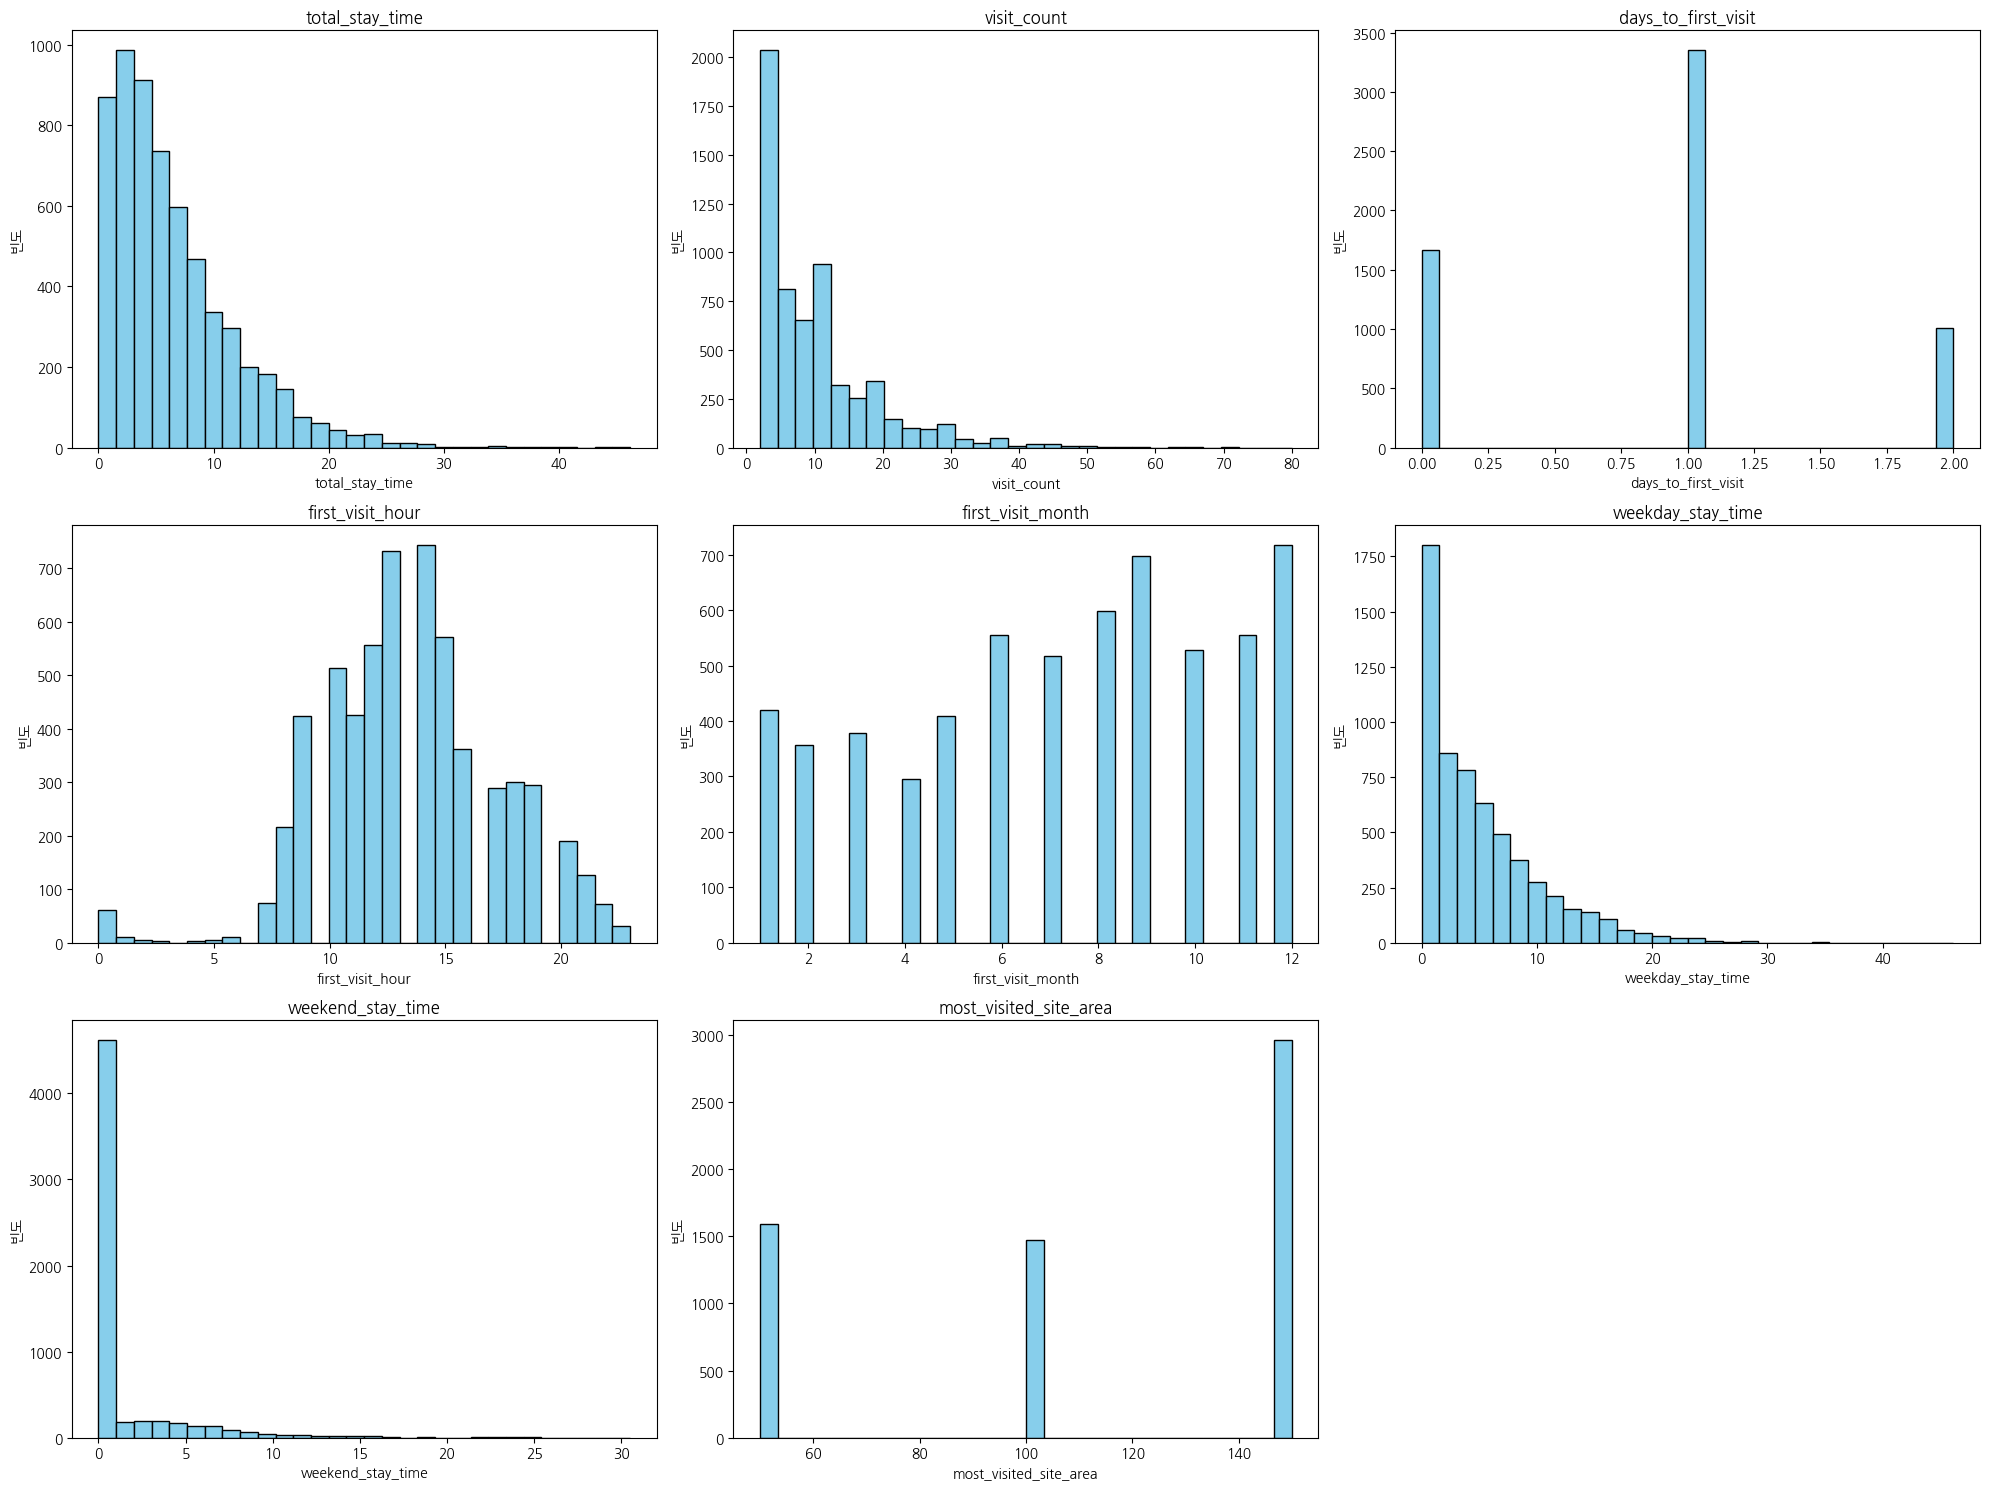

In [52]:
# 그래프 레이아웃 설정
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# final_merged_data의 관련 수치 변수에 대한 히스토그램 그리기
variables = [
    'total_stay_time',  # 총 체류 시간
    'visit_count',  # 방문 횟수
    'days_to_first_visit',  # 첫 방문까지 걸린 일수
    'first_visit_hour',  # 첫 방문 시간
    'first_visit_month',  # 첫 방문 월
    'weekday_stay_time',  # 평일 체류 시간
    'weekend_stay_time',  # 주말 체류 시간
    'most_visited_site_area'  # 가장 많이 방문한 사이트 영역
]

titles = [
    'total_stay_time',
    'visit_count',
    'days_to_first_visit',
    'first_visit_hour',
    'first_visit_month',
    'weekday_stay_time',
    'weekend_stay_time',
    'most_visited_site_area'
]

for i, var in enumerate(variables):
    axes[i].hist(final_merged_data[var].dropna(), bins=30, color='skyblue', edgecolor='black')  # 히스토그램 생성
    axes[i].set_title(titles[i])  # 그래프 제목 설정
    axes[i].set_xlabel(var)  # x축 라벨 설정
    axes[i].set_ylabel('빈도')  # y축 라벨 설정

# 사용되지 않은 서브플롯 숨기기
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # 레이아웃 조정
plt.show()

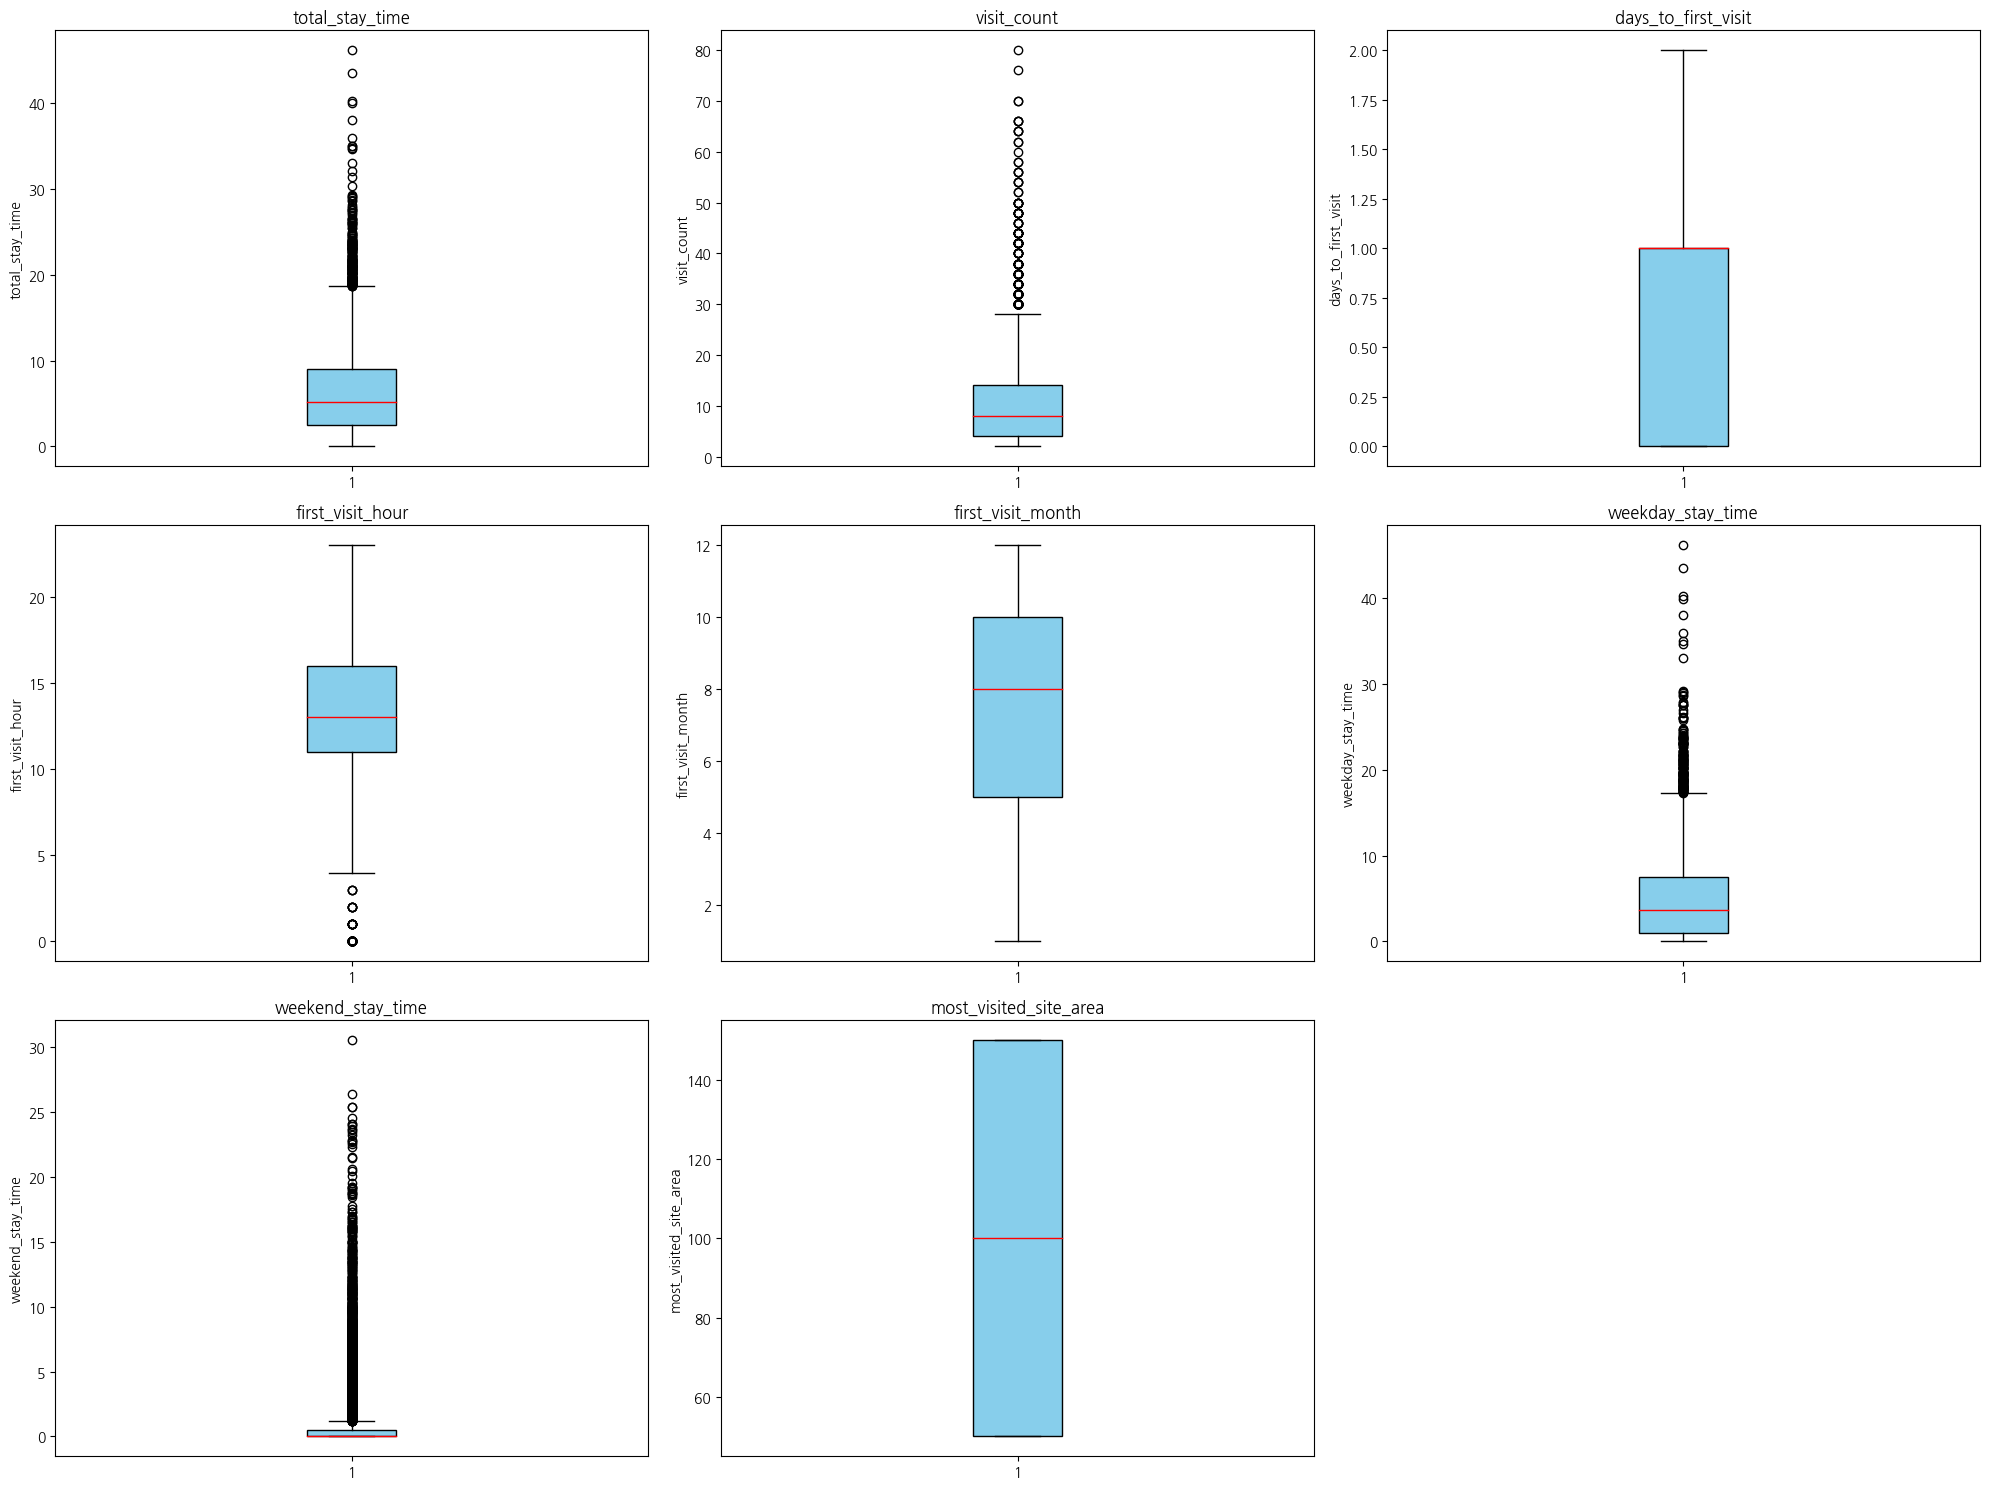

In [53]:
import matplotlib.pyplot as plt

# 그래프 레이아웃 설정
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# final_merged_data의 관련 수치 변수에 대한 박스 플롯 그리기
variables = [
    'total_stay_time',  # 총 체류 시간
    'visit_count',  # 방문 횟수
    'days_to_first_visit',  # 첫 방문까지 걸린 일수
    'first_visit_hour',  # 첫 방문 시간
    'first_visit_month',  # 첫 방문 월
    'weekday_stay_time',  # 평일 체류 시간
    'weekend_stay_time',  # 주말 체류 시간
    'most_visited_site_area'  # 가장 많이 방문한 사이트 영역
]

titles = [
    'total_stay_time',
    'visit_count',
    'days_to_first_visit',
    'first_visit_hour',
    'first_visit_month',
    'weekday_stay_time',
    'weekend_stay_time',
    'most_visited_site_area'
]

for i, var in enumerate(variables):
    axes[i].boxplot(final_merged_data[var].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(titles[i])  # 그래프 제목 설정
    axes[i].set_ylabel(var)  # y축 라벨 설정
    axes[i].set_xlabel('')  # x축 라벨 제거

# 사용되지 않은 서브플롯 숨기기
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # 레이아웃 조정
plt.show()

- i.	총 체류시간 : 대부분의 유저는 무료체험 기간 3일 동안 총 체류 시간이 12시간(43,200초) 미만으로 이용시간이 짧은 것으로 관찰됨

- ii.	입실/퇴실 빈도 : 무료체험 기간 동안 입실과 퇴실의 빈도가 20회 미만으로 낮은 값에 밀집되어 있음
- iii.	첫 방문까지 걸린 일수 : 대부분의 유저는 무료체험 신청 후 다음날에 방문하는 것으로 관찰됨
- iv.	첫 방문 시간대 : 무료체험 신청후 첫방문 시간으로는 업무 시간대(9시~17시)에 집중되어 있음
- v.	첫 방문 월 : 연초보다 연말에 무료체험 유저가 집중되는 경향이 관찰됨
- vi.	주중/주말 체류시간 : 주말보다 주중의 체류시간이 조금 더 길게 이용하는 것으로 관찰됨
- vii.	선호하는 지점의 평수 : 평수가 넓은 지점이 유저가 더 많이 방문하는 것으로 관찰됨


###결제 여부에 따른 체류시간 비교###

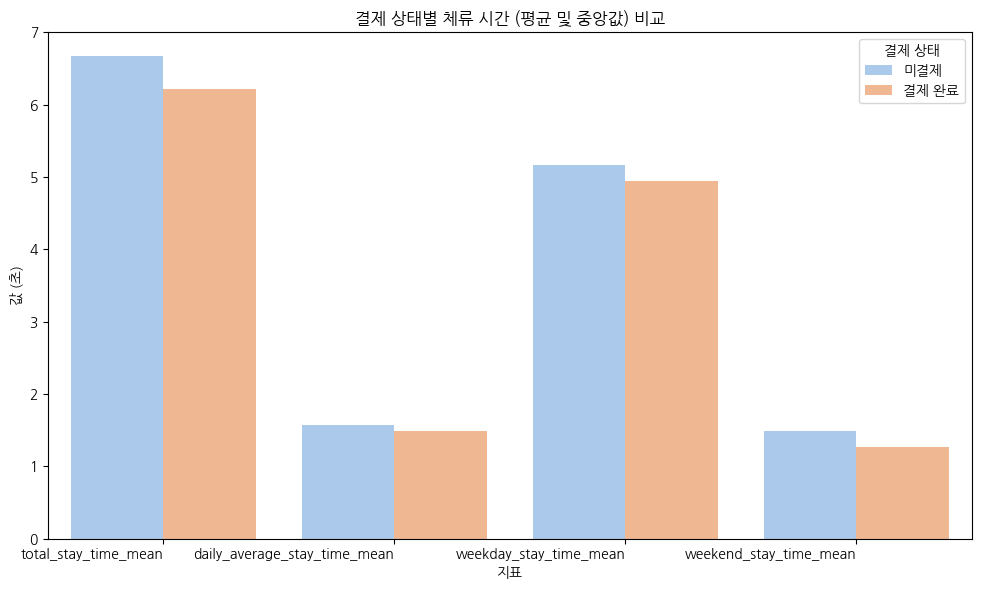

In [54]:
# 결제 상태별 체류 시간 평균과 중앙값 계산
stay_time_stats = final_merged_data.groupby('is_payment').agg(
    total_stay_time_mean=('total_stay_time', 'mean'),  # 총 체류 시간 평균
    daily_average_stay_time_mean=('daily_average_stay_time', 'mean'),  # 일일 평균 체류 시간
    weekday_stay_time_mean=('weekday_stay_time', 'mean'),  # 평일 체류 시간 평균
    weekend_stay_time_mean=('weekend_stay_time', 'mean'),  # 주말 체류 시간 평균
).reset_index()

# 결제 상태 레이블 추가
stay_time_stats['Payment_Status'] = stay_time_stats['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 시각화를 위한 데이터 형태 변경
stay_time_stats_melted = stay_time_stats.melt(
    id_vars=['Payment_Status'],  # 고정할 열
    value_vars=[
        'total_stay_time_mean',
        'daily_average_stay_time_mean',
        'weekday_stay_time_mean',
        'weekend_stay_time_mean',
    ],  # 녹일 열 목록
    var_name='Metric',  # 녹여진 열의 이름
    value_name='Value'  # 값 열의 이름
)

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stay_time_stats_melted,
    x='Metric', y='Value', hue='Payment_Status', palette="pastel"
)
plt.xticks(rotation = 0, ha='right')
plt.title('결제 상태별 체류 시간 (평균 및 중앙값) 비교')
plt.xlabel('지표')
plt.ylabel('값 (초)')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 유료 결제로 전환하지 않은 유저가 평균적으로 더 긴 체류시간을 갖는 것으로 관찰됨.
- 이는 체류시간이 결제 여부를 결정하는 중요한 요인이 아닐 수 있음을 시사.

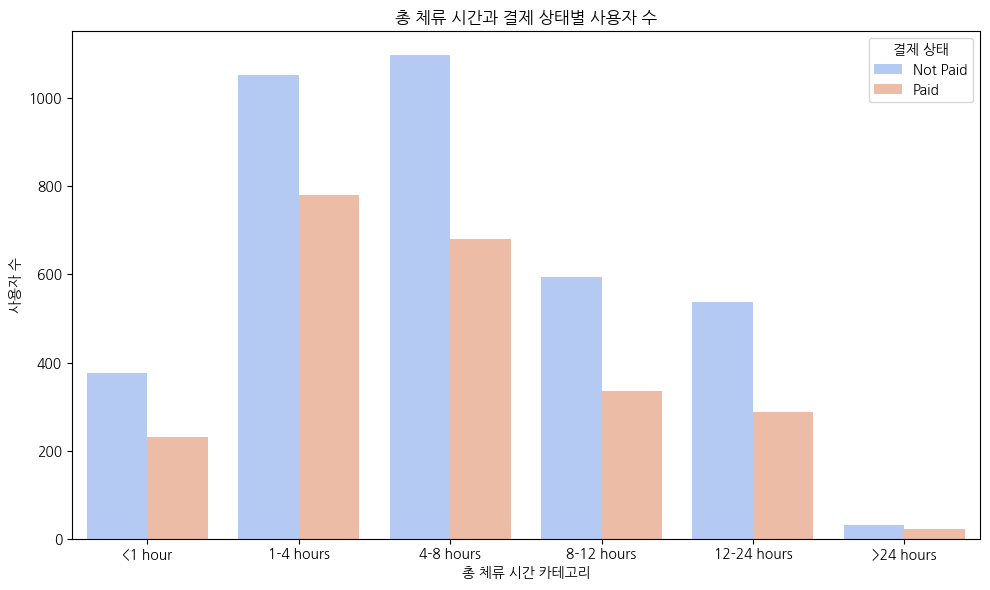

In [55]:
# total_stay_time(시간 단위)을 기준으로 구간 생성
bins = [0, 1, 4, 8, 12, 24, float('inf')]  # 시간 범위
labels = ['<1 hour', '1-4 hours', '4-8 hours', '8-12 hours', '12-24 hours', '>24 hours']

# 데이터를 구간화된 열로 추가
final_merged_data['stay_time_category'] = pd.cut(
    final_merged_data['total_stay_time'], bins=bins, labels=labels, right=False
)

# stay_time_category와 is_payment 기준으로 데이터 그룹화
stay_time_summary = final_merged_data.groupby(['stay_time_category', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
stay_time_summary['Payment_Status'] = stay_time_summary['is_payment'].map({0: 'Not Paid', 1: 'Paid'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stay_time_summary,
    x='stay_time_category',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('총 체류 시간과 결제 상태별 사용자 수')
plt.xlabel('총 체류 시간 카테고리')
plt.ylabel('사용자 수')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 체류시간 구간별 결제 여부를 확인해보니, 모든 시간대에서 유료 결제로 전환되지 않은 유저가 더 오래 이용하는 것으로 관찰됨.
- 특히, 1-4시간, 4-8시간 공유오피스를 이용한 유저층에서 유료 결제로 전환되지 않은 유저가 더 많은 경향이 관찰됨.

###결제 여부에 따른 입실/퇴실 빈도 비교

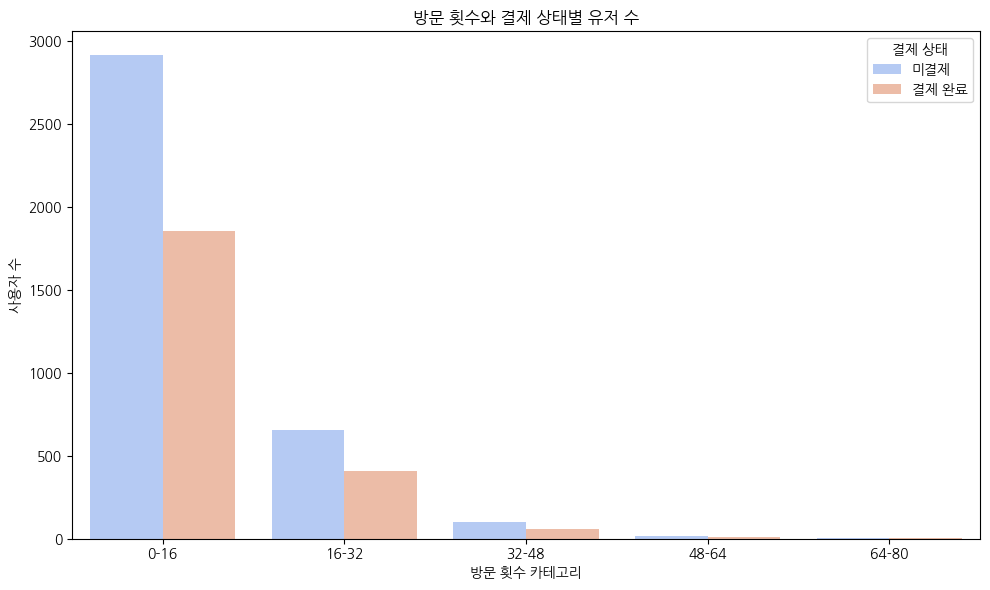

In [30]:
# visit_count에 대한 구간 생성
visit_bins = [0, 16, 32, 48, 64, 80]
visit_labels = ['0-16', '16-32', '32-48', '48-64', '64-80']

# 데이터에 구간화된 열 추가
final_merged_data['visit_count_category'] = pd.cut(
    final_merged_data['visit_count'], bins=visit_bins, labels=visit_labels, right=False
)

# visit_count_category와 is_payment를 기준으로 데이터 그룹화
visit_count_summary = final_merged_data.groupby(['visit_count_category', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
visit_count_summary['Payment_Status'] = visit_count_summary['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=visit_count_summary,
    x='visit_count_category',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('방문 횟수와 결제 상태별 유저 수')
plt.xlabel('방문 횟수 카테고리')
plt.ylabel('사용자 수')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 입실/퇴실 빈도도 체류시간과 비슷한 양상으로 유료 결제로 전환되지 않은 유저가 입실과 퇴실을 더 많이 행동한 것으로 관찰됨.

###체험 신청일과 첫 방문일 간 차이 분석

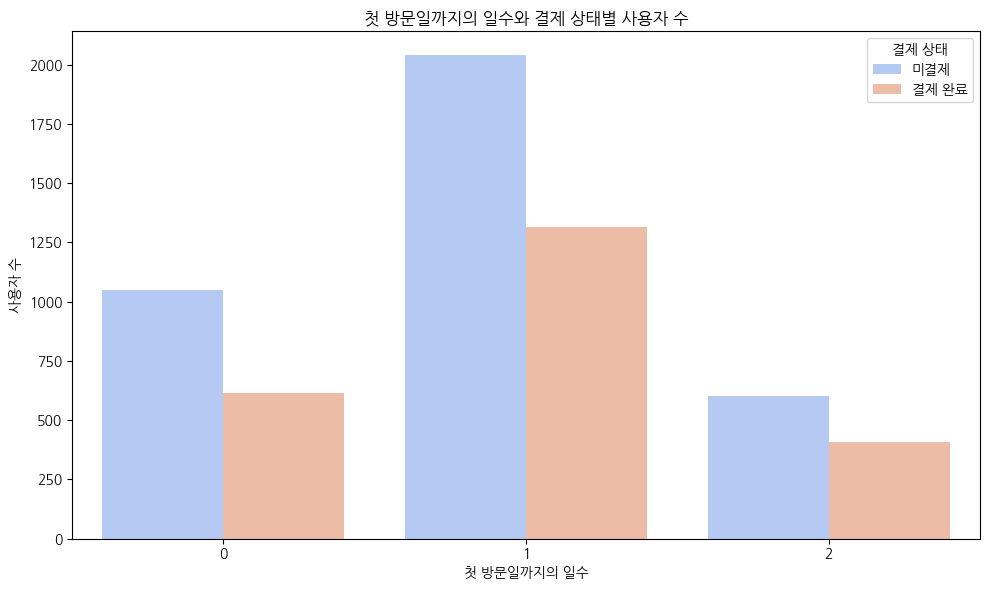

In [32]:
# days_to_first_visit와 is_payment를 기준으로 데이터 그룹화
days_to_first_visit_summary = final_merged_data.groupby(['days_to_first_visit', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
days_to_first_visit_summary['Payment_Status'] = days_to_first_visit_summary['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=days_to_first_visit_summary,
    x='days_to_first_visit',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('첫 방문일까지의 일수와 결제 상태별 사용자 수')
plt.xlabel('첫 방문일까지의 일수')
plt.ylabel('사용자 수')
plt.legend(title='결제 상태', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- 무료체험을 신청한 유저는 2일 이내 방문하는 것으로 관찰됐으며, 결제 전환 여부와 상관없이 무료체험 신청 후 1일 후 방문하는 것으로 관찰됨

###결제 여부에 따른 지점 선호도

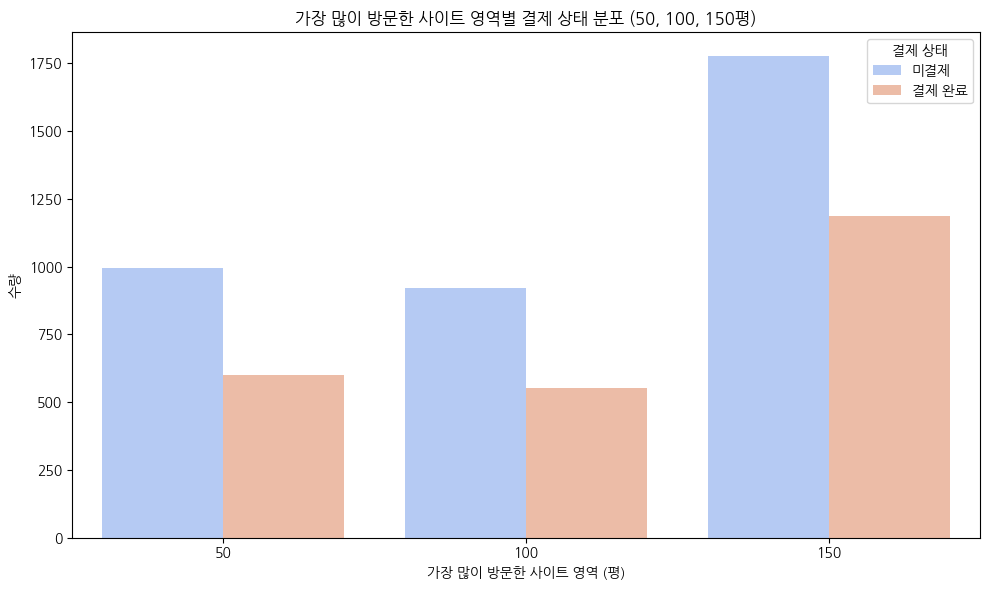

In [33]:
# 'most_visited_site_area'와 'is_payment'를 기준으로 정확한 카테고리 그룹화
site_area_payment_analysis = final_merged_data.groupby(['most_visited_site_area', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
site_area_payment_analysis['Payment_Status'] = site_area_payment_analysis['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=site_area_payment_analysis,
    x='most_visited_site_area',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('가장 많이 방문한 사이트 영역별 결제 상태 분포 (50, 100, 150평)')
plt.xlabel('가장 많이 방문한 사이트 영역 (평)')
plt.ylabel('수량')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 평수가 넓은 공유오피스를 선호하는 것으로 관찰됨

###결제 여부에 따른 요일 패턴

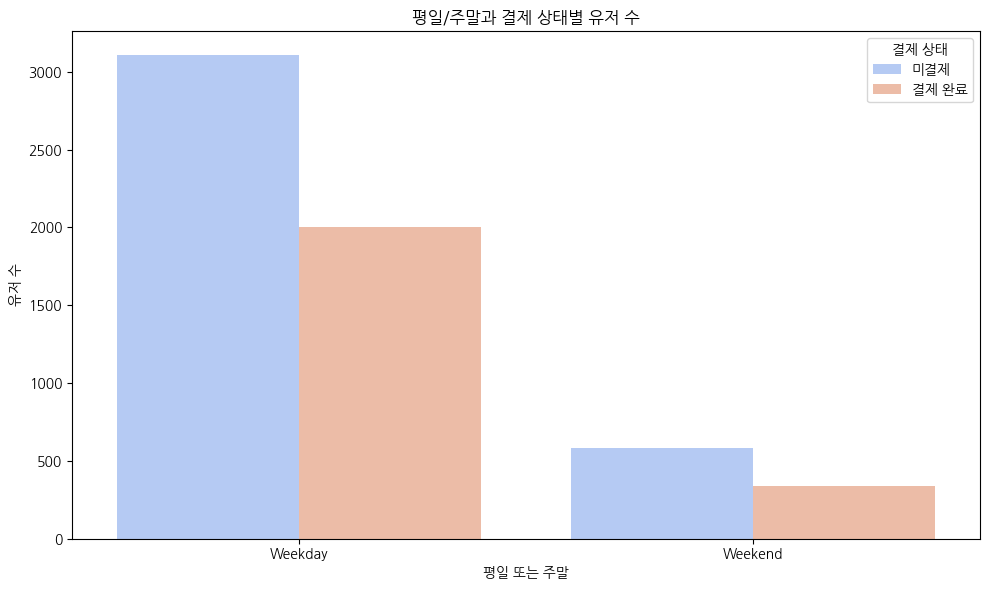

In [34]:
# weekday_or_weekend와 is_payment를 기준으로 데이터 그룹화
weekday_weekend_summary = final_merged_data.groupby(['weekday_or_weekend', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
weekday_weekend_summary['Payment_Status'] = weekday_weekend_summary['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=weekday_weekend_summary,
    x='weekday_or_weekend',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('평일/주말과 결제 상태별 유저 수')
plt.xlabel('평일 또는 주말')
plt.ylabel('유저 수')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 공유오피스 이용은 주말보다 평일에 방문하는 것으로 관찰됨

### 무료체험 신청 후 첫 방문한 유저 비교

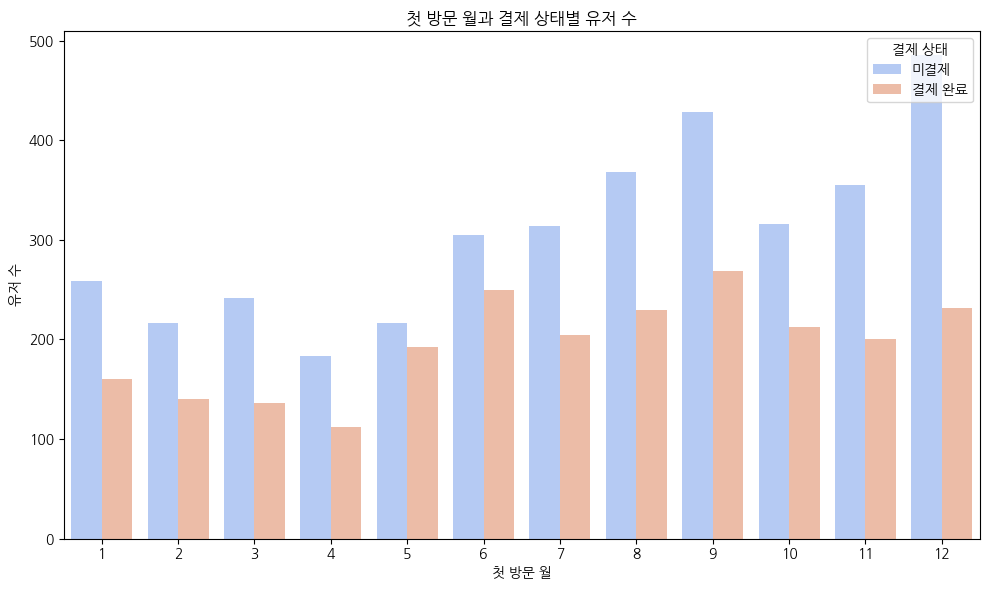

In [35]:
# first_visit_month와 is_payment를 기준으로 데이터 그룹화
first_visit_month_summary = final_merged_data.groupby(['first_visit_month', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
first_visit_month_summary['Payment_Status'] = first_visit_month_summary['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=first_visit_month_summary,
    x='first_visit_month',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('첫 방문 월과 결제 상태별 유저 수')
plt.xlabel('첫 방문 월')
plt.ylabel('유저 수')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 무료체험 신청 유저의 첫 방문 월을 비교해보니, 유료 결제로 전환되지 않은 유저는 12월, 9월, 8월에 가장 많이 방문하였고, 유료 결제로 전환된 유저는 9월, 6월, 8월에 가장 많이 방문한것으로 관찰됨.

### 결제 여부에 따른 첫 방문 시간 비교

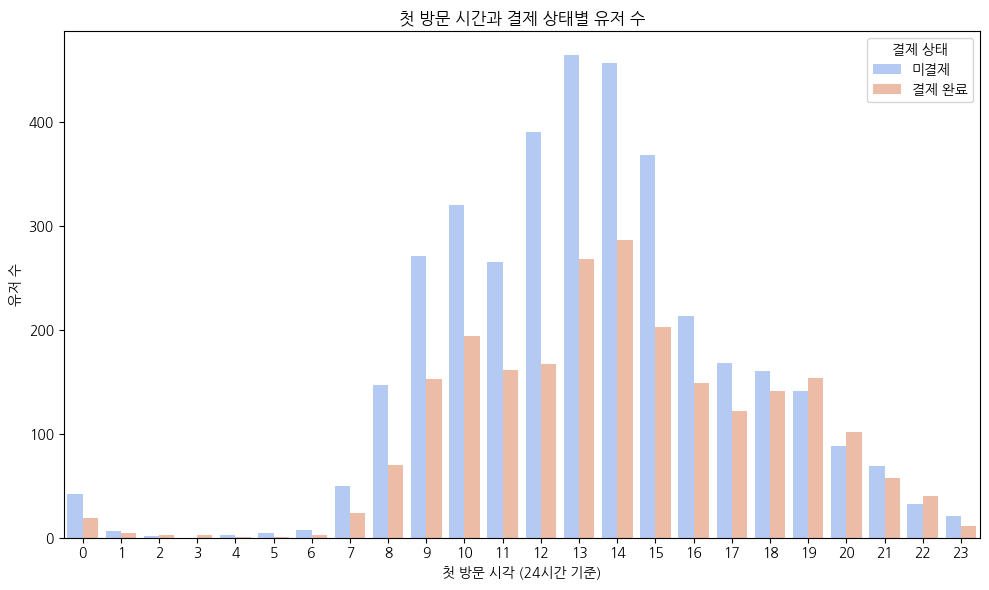

In [36]:
# first_visit_hour와 is_payment를 기준으로 데이터 그룹화
first_visit_hour_summary = final_merged_data.groupby(['first_visit_hour', 'is_payment']).size().reset_index(name='count')

# 결제 상태 레이블 추가
first_visit_hour_summary['Payment_Status'] = first_visit_hour_summary['is_payment'].map({0: '미결제', 1: '결제 완료'})

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(
    data=first_visit_hour_summary,
    x='first_visit_hour',
    y='count',
    hue='Payment_Status',
    palette="coolwarm"
)
plt.title('첫 방문 시간과 결제 상태별 유저 수')
plt.xlabel('첫 방문 시각 (24시간 기준)')
plt.ylabel('유저 수')
plt.legend(title='결제 상태', loc='upper right')
plt.tight_layout()
plt.show()

- 첫 방문 시간을 비교해보니, 오후 12시부터 15시까지 가장 많이 방문한 것으로 관찰됨.
- 대부분의 시간대에서 비결제 유저의 수가 많지만, 오후 6시에서 오후 8시쯤에 결제 유저의 비율이 증가함.

### 월별 방문 빈도

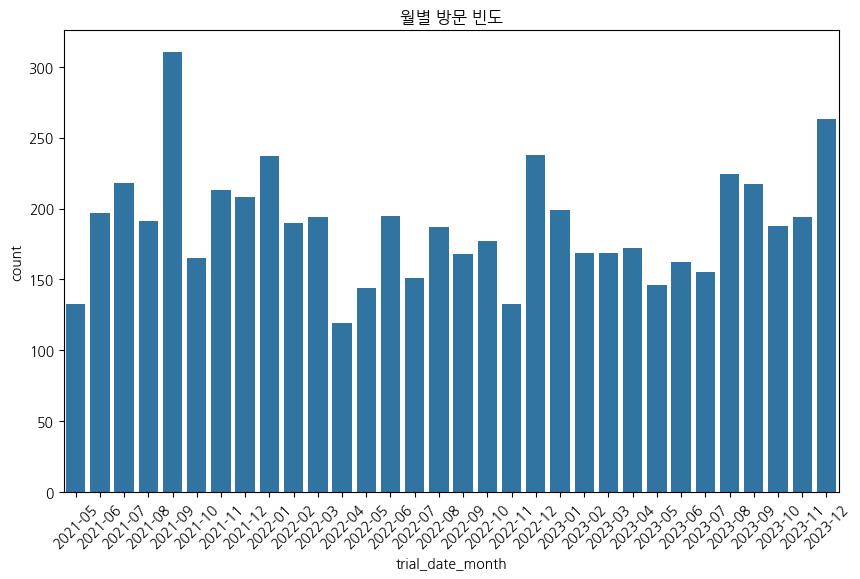

In [37]:
plt.figure(figsize=(10, 6))
final_merged_data['trial_date_month'] = final_merged_data['trial_date'].dt.to_period('M')
sns.countplot(x='trial_date_month', data=final_merged_data, order=sorted(final_merged_data['trial_date_month'].unique()))
plt.title('월별 방문 빈도')
plt.xticks(rotation=45)
plt.show()

- 2021년 9월을 제외하고 대체적으로 연말 시즌에 유입되는 유저들이 많은 것으로 보임.

###일별 평균 재실 시간

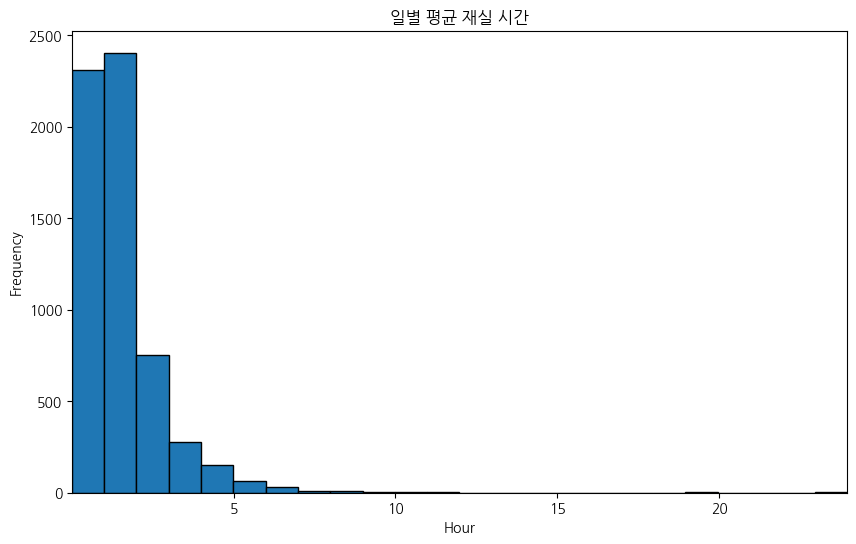

In [38]:
#일별 평균 재실 시간
plt.figure(figsize=(10, 6))
plt.hist(final_merged_data['daily_average_stay_time'], bins=24, edgecolor='black')
plt.xlim(final_merged_data['daily_average_stay_time'].min(), final_merged_data['daily_average_stay_time'].max())

plt.title('일별 평균 재실 시간')
plt.xlabel('Hour')
plt.ylabel('Frequency')

plt.show()

- 일별 평균 재실시간 대부분이 3시간 이내에 분포되어 있음.

### 재실시간 관련 컬럼 분포

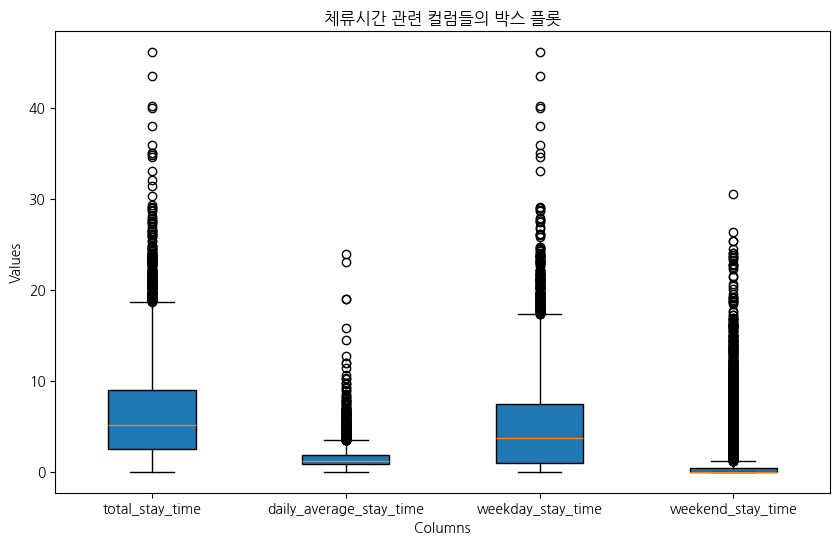

In [180]:
# 박스플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot([final_merged_data[col].dropna() for col in time_columns], labels=time_columns, patch_artist=True)

# 제목 및 축 레이블 설정
plt.title('체류시간 관련 컬럼들의 박스 플롯')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

- 총 재실 시간, 일별 평균 재실 시간, 평일/주말 재실시간으로 나누어 Boxplot를 그려 데이터의 분포를 확인함.
- 3일 무료 체험 기간동안 전체 재실시간은 약 4~9시간 정도로 하루에 약 3시간 미만으로 공부를 하는 것이 대다수임.

In [35]:
final_merged_data.head(2)

,trial_date,user_uuid,weekday_or_weekend,day_of_week,is_payment,total_stay_time,daily_average_stay_time,weekday_stay_time,weekend_stay_time,weekend_days,...,total_sites_visited,most_visited_site,most_visited_site_area,first_visit_hour,first_visit_year,first_visit_month,first_visit_day,visit_count,days_to_first_visit,trial_date_month
0,2023-09-04,000590dc-046f-462b-8225-4c81a97b7166,Weekday,Monday,0,5.949167,1.983056,5.949167,0.0,0,...,1,6,150,11,2023,9,5,6,1,2023-09
1,2021-09-29,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,Weekday,Wednesday,1,5.446111,0.605123,5.446111,0.0,0,...,1,3,150,16,2021,9,30,18,1,2021-09


In [36]:
most_visited = final_merged_data['most_visited_site'].value_counts().reset_index()
most_visited

,most_visited_site,count
0,3,1237
1,6,1172
2,2,1007
3,1,758
4,5,555
5,4,463
6,17,415
7,47,291
8,49,128


In [37]:
# total_sites_visited 기준으로 상위 10명의 유저들 정렬
top_10_users = final_merged_data[['user_uuid', 'total_sites_visited']].sort_values(by='total_sites_visited', ascending=False).drop_duplicates().head(10)

# 결과 확인
print(top_10_users)

                                 user_uuid  total_sites_visited
1436  3b371ed1-3ef5-450d-ba29-b4e71fdc1bc4                    4
3677  9ae30b10-8729-44f7-8f27-ed94f292c2b1                    4
2335  6149dd69-31d7-43b8-9a31-92fff29bebc3                    3
3545  953a48a9-1292-4353-ad72-5c99dd47ae28                    3
4067  ab13af14-43b8-4ecc-a9ca-6e2bf3c28c87                    3
5472  e80f7f66-f24a-4637-95c9-20288fd811ee                    3
3317  8ab044af-7a92-4b31-b886-bc1c5cd58987                    3
2154  59689389-e601-4801-95f7-2d89d5ed53f5                    3
1336  366dd7b1-aa7d-4519-bb86-cf2a4b0e07ca                    3
140   05a9cf4a-ceaf-4396-ac13-7db53c1ca393                    3


하루에 2지점 이상을 방문한 유저가 있음.

In [38]:
# total_sites_visited 기준으로 상위 10명의 와리가리 유저 정렬
top_10_users = final_merged_data[['user_uuid', 'visit_count']].sort_values(by='visit_count', ascending=False).drop_duplicates().head(10)

# 결과 확인
print(top_10_users)

                                 user_uuid  visit_count
5263  dfcf88d6-b293-4598-89c0-6598865e3fd9           80
1809  4b148aaf-0149-4d63-81ba-0cae91598ff2           76
2179  5a8723ea-4207-4d94-ab06-d7f7d7de8b61           70
1684  4622f625-f93d-4f65-9e9a-e7b24171da62           70
3278  891127aa-959d-4788-a836-dfcc9cf5bfdf           66
4790  ca76e5bd-5e76-47ff-9ef9-f0fac8b64edd           66
2248  5d4058cb-528a-45b1-a2dd-7cf2cc6c401a           66
1545  3fdd37d0-6cfa-4d6f-866b-91b25d3f9ad4           64
1065  29787639-0033-4372-acb8-5400e40f9ddd           64
2835  7703c928-369a-4316-bae6-2d932287c9f6           64


장염 환자나 흡연자로 예측

In [39]:
# visit_count의 전체 평균 계산
visit_count_mean = final_merged_data['visit_count'].mean()

# 결과 출력
print(visit_count_mean)

10.155326916694325


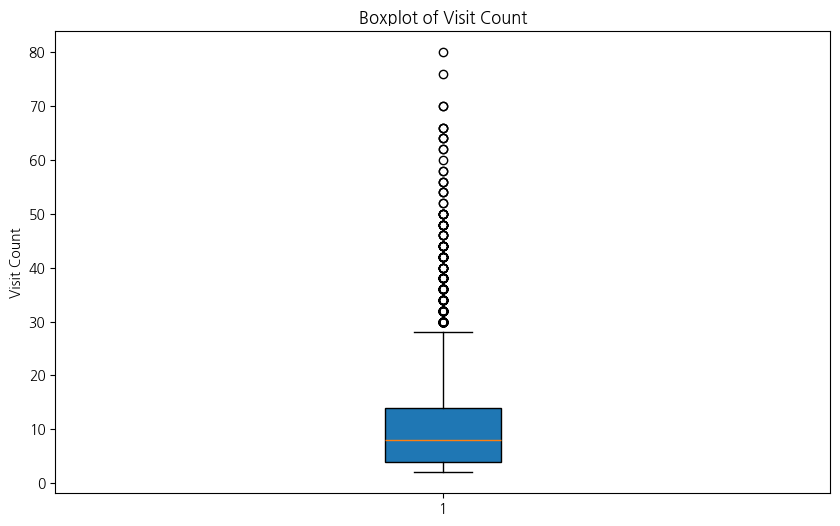

In [175]:
# 박스플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(final_merged_data['visit_count'].dropna(), patch_artist=True)

# 축 및 제목 설정
plt.title('Boxplot of Visit Count')
plt.ylabel('Visit Count')
plt.show()

- Boxplot을 그려 총 방문 횟수의 분포를 확인한 결과 약 5회 ~ 15회임을 알 수 있음.
- 일부 유저들의 방문 횟수는 40회 이상을 기록 했으며 그 중 70회 이상을 방문한 헤비 유저도 존재했음.
- 헤비 유저(이상치를 구성하는 유저)들을 따로 추출하여 해당 유저들의 방문 시간대를 파악하여 어떤 특성이 있는지 확인 할 필요가 있음.

보통 입퇴실 시간을 다 합쳐서 10번 내외이다.

###결제 여부에 따른 체류 시간(총합) 분포 비교

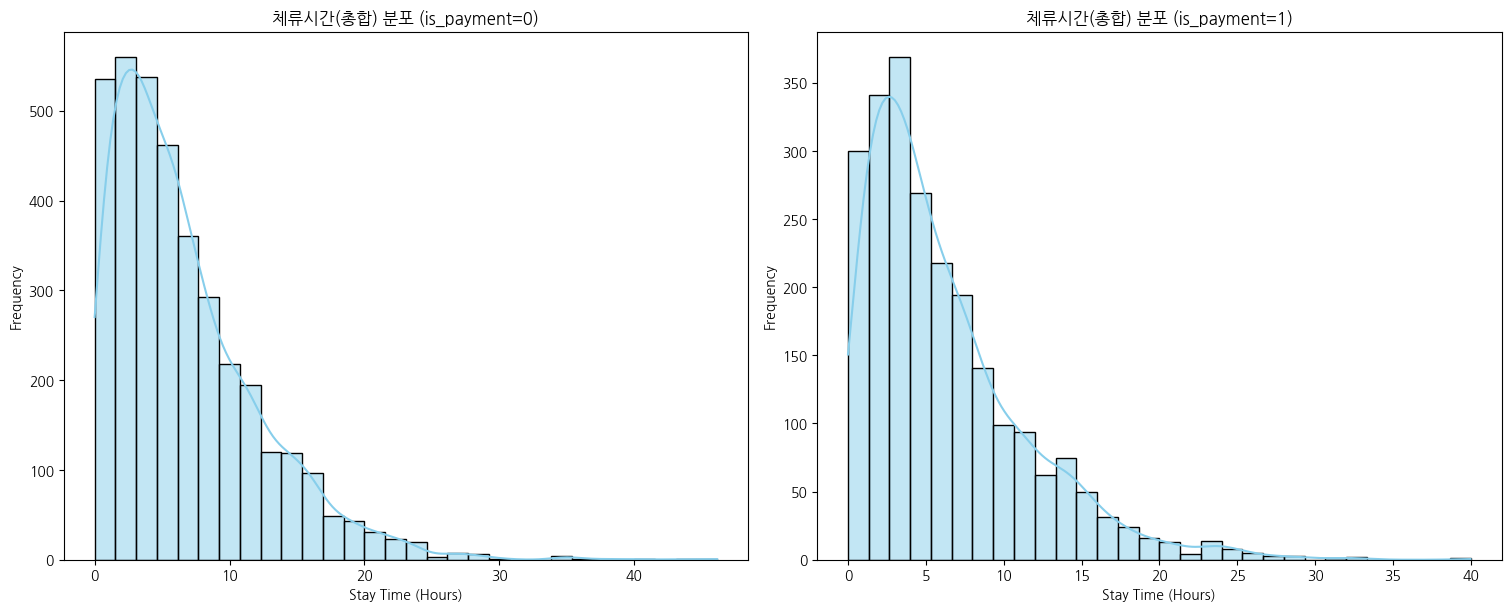

In [185]:
groups = final_merged_data.groupby('is_payment')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

for ax, (group, data) in zip(axes, groups):
    sns.histplot(data['total_stay_time'], bins=30, kde=True, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"체류시간(총합) 분포 (is_payment={group})")
    ax.set_xlabel('Stay Time (Hours)')
    ax.set_ylabel('Frequency')

plt.show()

- 총 재실 시간 분포를 유료 비전환/전환 고객으로 나누어 그래프를 그렸을 때 무료체험 후 유료로 전환하지 않은 사용자들과 유료로 전환한 사용자들의 이용 분포는 뚜렷한 차이를 띄지 않음.
- 유료 전환 한 사용자들이 하지 않은 사용자보다 전반적으로 체류 시간이 조금 더 짧으며 체류 시간이 긴 사용자는 유료 전환을 하지 않은 사용자보다 비교적 적음.
- 이는 재실 시간이 무료 체험 후 유료 전환의 주요 결정 요인이 아닐 가능성이 클 것을 시사함

###결제 여부에 따른 체류 시간(일평균) 분포 비교

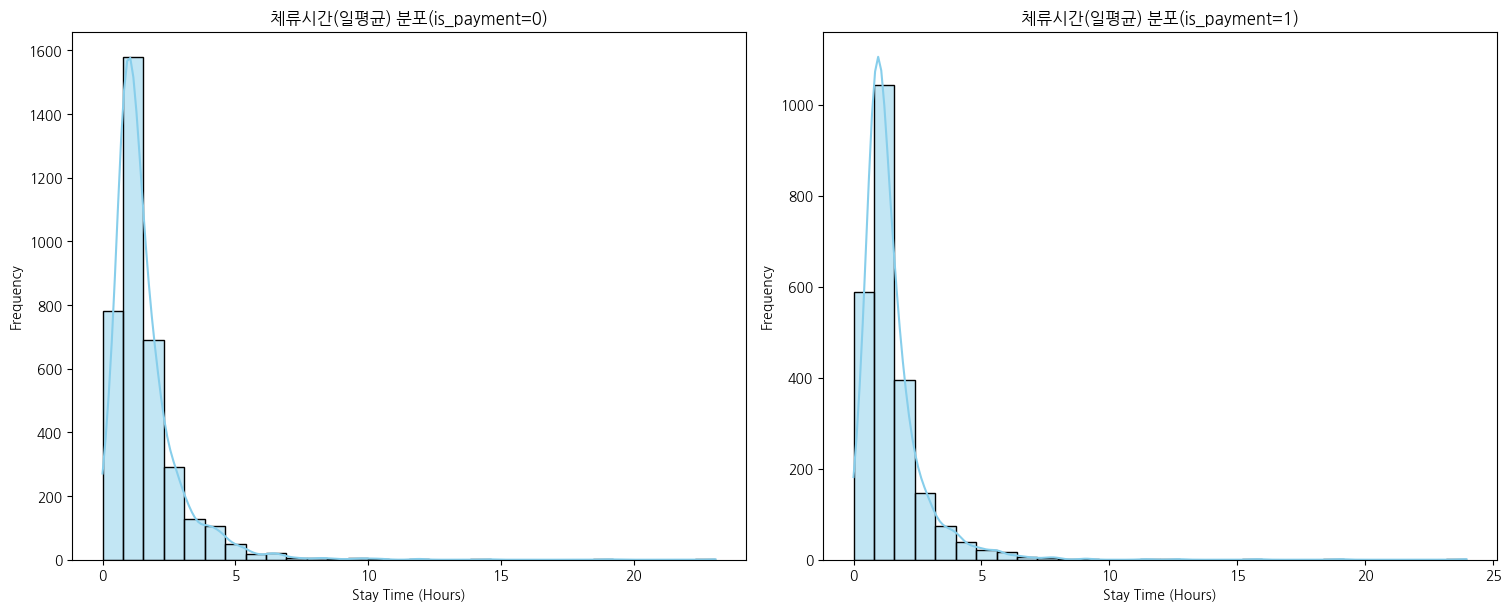

In [186]:
groups = final_merged_data.groupby('is_payment')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

for ax, (group, data) in zip(axes, groups):
    sns.histplot(data['daily_average_stay_time'], bins=30, kde=True, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"체류시간(일평균) 분포(is_payment={group})")
    ax.set_xlabel('Stay Time (Hours)')
    ax.set_ylabel('Frequency')

plt.show()

- 일별 평균 재실 시간 역시 유료 전환의 주요 결정 요인이 아닐 가능성이 높아 보임.
- 유료 전환 유저와 아닌 유저의 사용 분포가 매우 유사하고 다른 큰 차이가 없어 보임.

###월별 유저 수 및 결제 여부에 따른 유저 비율

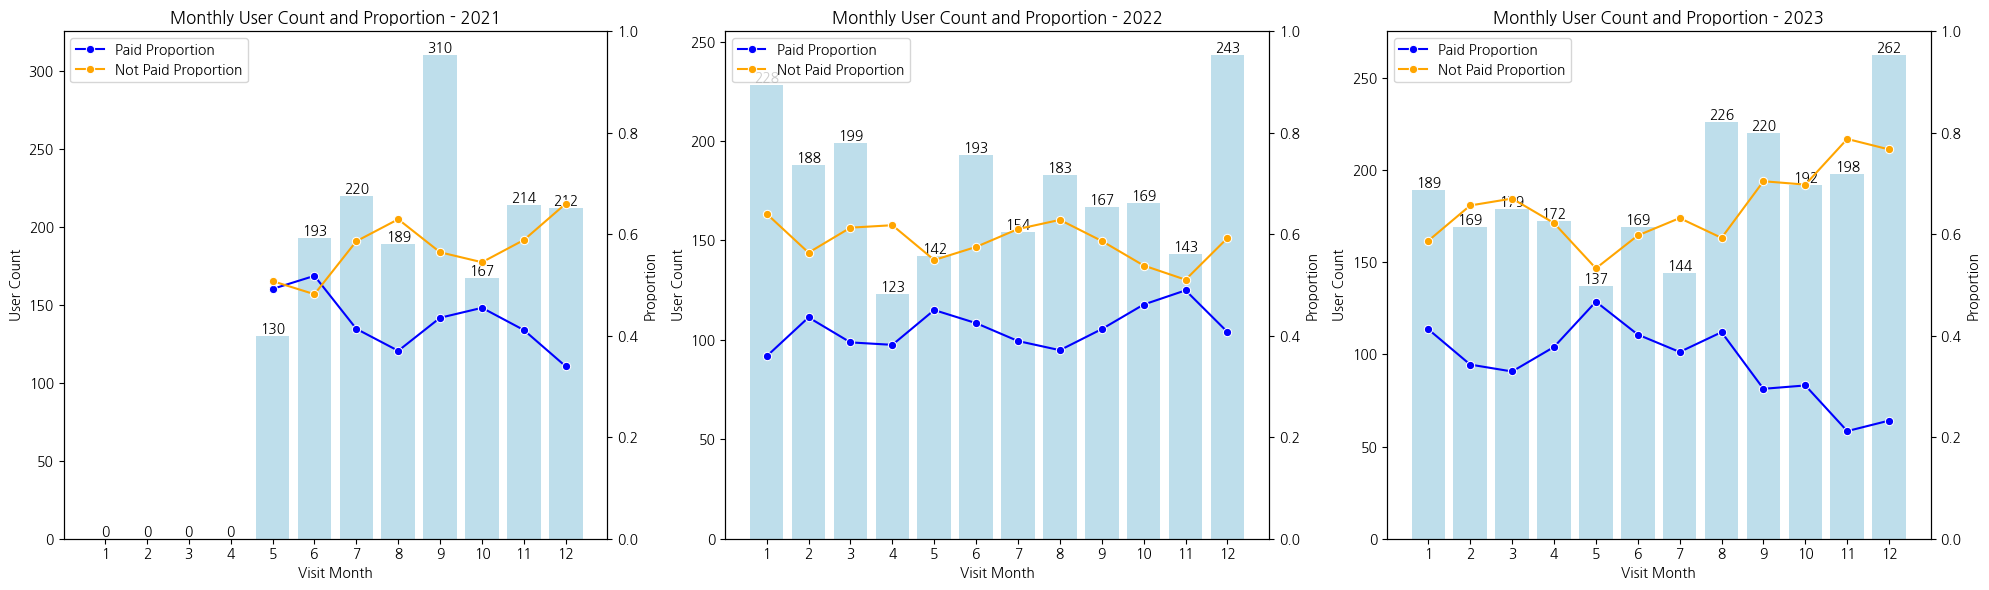

In [120]:
# 전체 기간 범위
years = [2021, 2022, 2023]
full_months = list(range(1, 13))

# first_visit_month를 문자열로 변환하고 카테고리로 설정
final_merged_data['first_visit_month'] = final_merged_data['first_visit_month'].astype(str)
final_merged_data['first_visit_month'] = pd.Categorical(
    final_merged_data['first_visit_month'],
    categories=[str(m) for m in full_months],
    ordered=True
)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for i, year in enumerate(years):
    yearly_data = final_merged_data[final_merged_data['first_visit_year'] == year]

    # 월별 사용자 수 집계
    monthly_summary = (
        yearly_data
        .groupby('first_visit_month')
        .size()
        .reindex([str(m) for m in full_months], fill_value=0)
        .reset_index()
    )
    monthly_summary.columns = ['first_visit_month', 'count']

    # 월별 payment 여부 비율 계산
    trial_month_summary = yearly_data.groupby(['first_visit_month', 'is_payment']).size().reset_index(name='count')
    trial_month_summary['total_count'] = trial_month_summary.groupby('first_visit_month')['count'].transform('sum')
    trial_month_summary['proportion'] = trial_month_summary['count'] / trial_month_summary['total_count']

    # Pivot
    pivot_data = (
        trial_month_summary
        .pivot(index='first_visit_month', columns='is_payment', values='proportion')
        .reindex([str(m) for m in full_months], fill_value=0)
        .reset_index()
    )
    pivot_data.columns = ['first_visit_month', 'Not Paid', 'Paid']

    # x값 (범주형이지만 순서 있는 카테고리)
    x_values = monthly_summary['first_visit_month']

    # 막대그래프 (User Count)
    bars = sns.barplot(
        data=monthly_summary,
        x='first_visit_month',
        y='count',
        ax=axes[i],
        color="skyblue",
        alpha=0.6,
        order=[str(m) for m in full_months]
    )
    axes[i].set_title(f'Monthly User Count and Proportion - {year}')
    axes[i].set_xlabel('Visit Month')
    axes[i].set_ylabel('User Count')
    for bar_container in bars.containers:
        bars.bar_label(bar_container, fmt='%.0f', label_type='edge')

    # Twin axis for proportions
    ax2 = axes[i].twinx()
    sns.lineplot(
        x=x_values,
        y=pivot_data['Paid'],
        label='Paid Proportion',
        marker='o',
        ax=ax2,
        color='blue',
        sort=False
    )
    sns.lineplot(
        x=x_values,
        y=pivot_data['Not Paid'],
        label='Not Paid Proportion',
        marker='o',
        ax=ax2,
        color='orange',
        sort=False
    )
    ax2.set_ylabel('Proportion')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper left')

    # x축 틱 강제 설정 (문자열 범주를 그대로 사용)
    axes[i].set_xticks(range(len(full_months)))
    axes[i].set_xticklabels(full_months)
    ax2.set_xticks(range(len(full_months)))
    ax2.set_xticklabels(full_months)

plt.tight_layout()
plt.show()

2021년 5월부터 2023년 12월까지 유저 수와 결제 비율을 시각화했다.

유저 수는 약간의 변동이 있지만 비결제 유저 비율은 증가하는 추세이고 결제 유저 비율은 감소하는 추세.

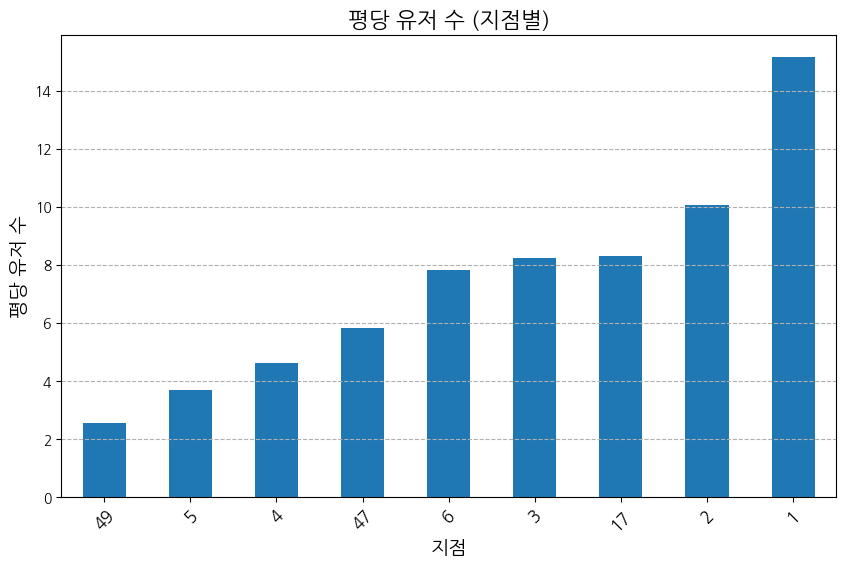

In [194]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. most_visited_site 기준으로 그룹화하여 각 지점별 총 유저 수 계산
site_user_count = final_merged_data.groupby('most_visited_site').size()

# 2. 각 지점별 고유한 면적(most_visited_site_area) 추출
site_area = final_merged_data.groupby('most_visited_site')['most_visited_site_area'].first()

# 3. 평당 유저 수 계산 (총 유저 수 / 지점 면적)
users_per_area = site_user_count / site_area

# 4. 시각화 (막대 그래프)
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
users_per_area.sort_values().plot(kind='bar')  # 평당 유저 수를 정렬하여 막대 그래프 생성
plt.title('평당 유저 수 (지점별)', fontsize=16)  # 그래프 제목
plt.xlabel('지점', fontsize=14)  # x축 라벨
plt.ylabel('평당 유저 수', fontsize=14)  # y축 라벨
plt.xticks(rotation=45, fontsize=12)  # x축 레이블 각도 및 폰트 크기 설정
plt.grid(axis='y', linestyle='--')  # y축 기준으로 그리드 추가
plt.show()  # 그래프 출력

지점별로 평당 유저 수가 높은 지점이 있고 낮은 지점이 있다.

그 차이와 원인을 분석할 필요가 있다.

                   Feature  T-Statistic       P-Value
0          total_stay_time    -3.189909  1.431704e-03
1  daily_average_stay_time    -2.594479  9.501142e-03
2        weekday_stay_time    -1.637363  1.016146e-01
3        weekend_stay_time    -2.695656  7.047007e-03
4             weekend_days    -2.367184  1.796033e-02
5             weekday_days     7.305184  3.214098e-13
6      total_sites_visited     1.288374  1.976782e-01
7   most_visited_site_area     1.709720  8.738001e-02
8              visit_count     0.103965  9.172013e-01
9      days_to_first_visit     1.950584  5.116254e-02


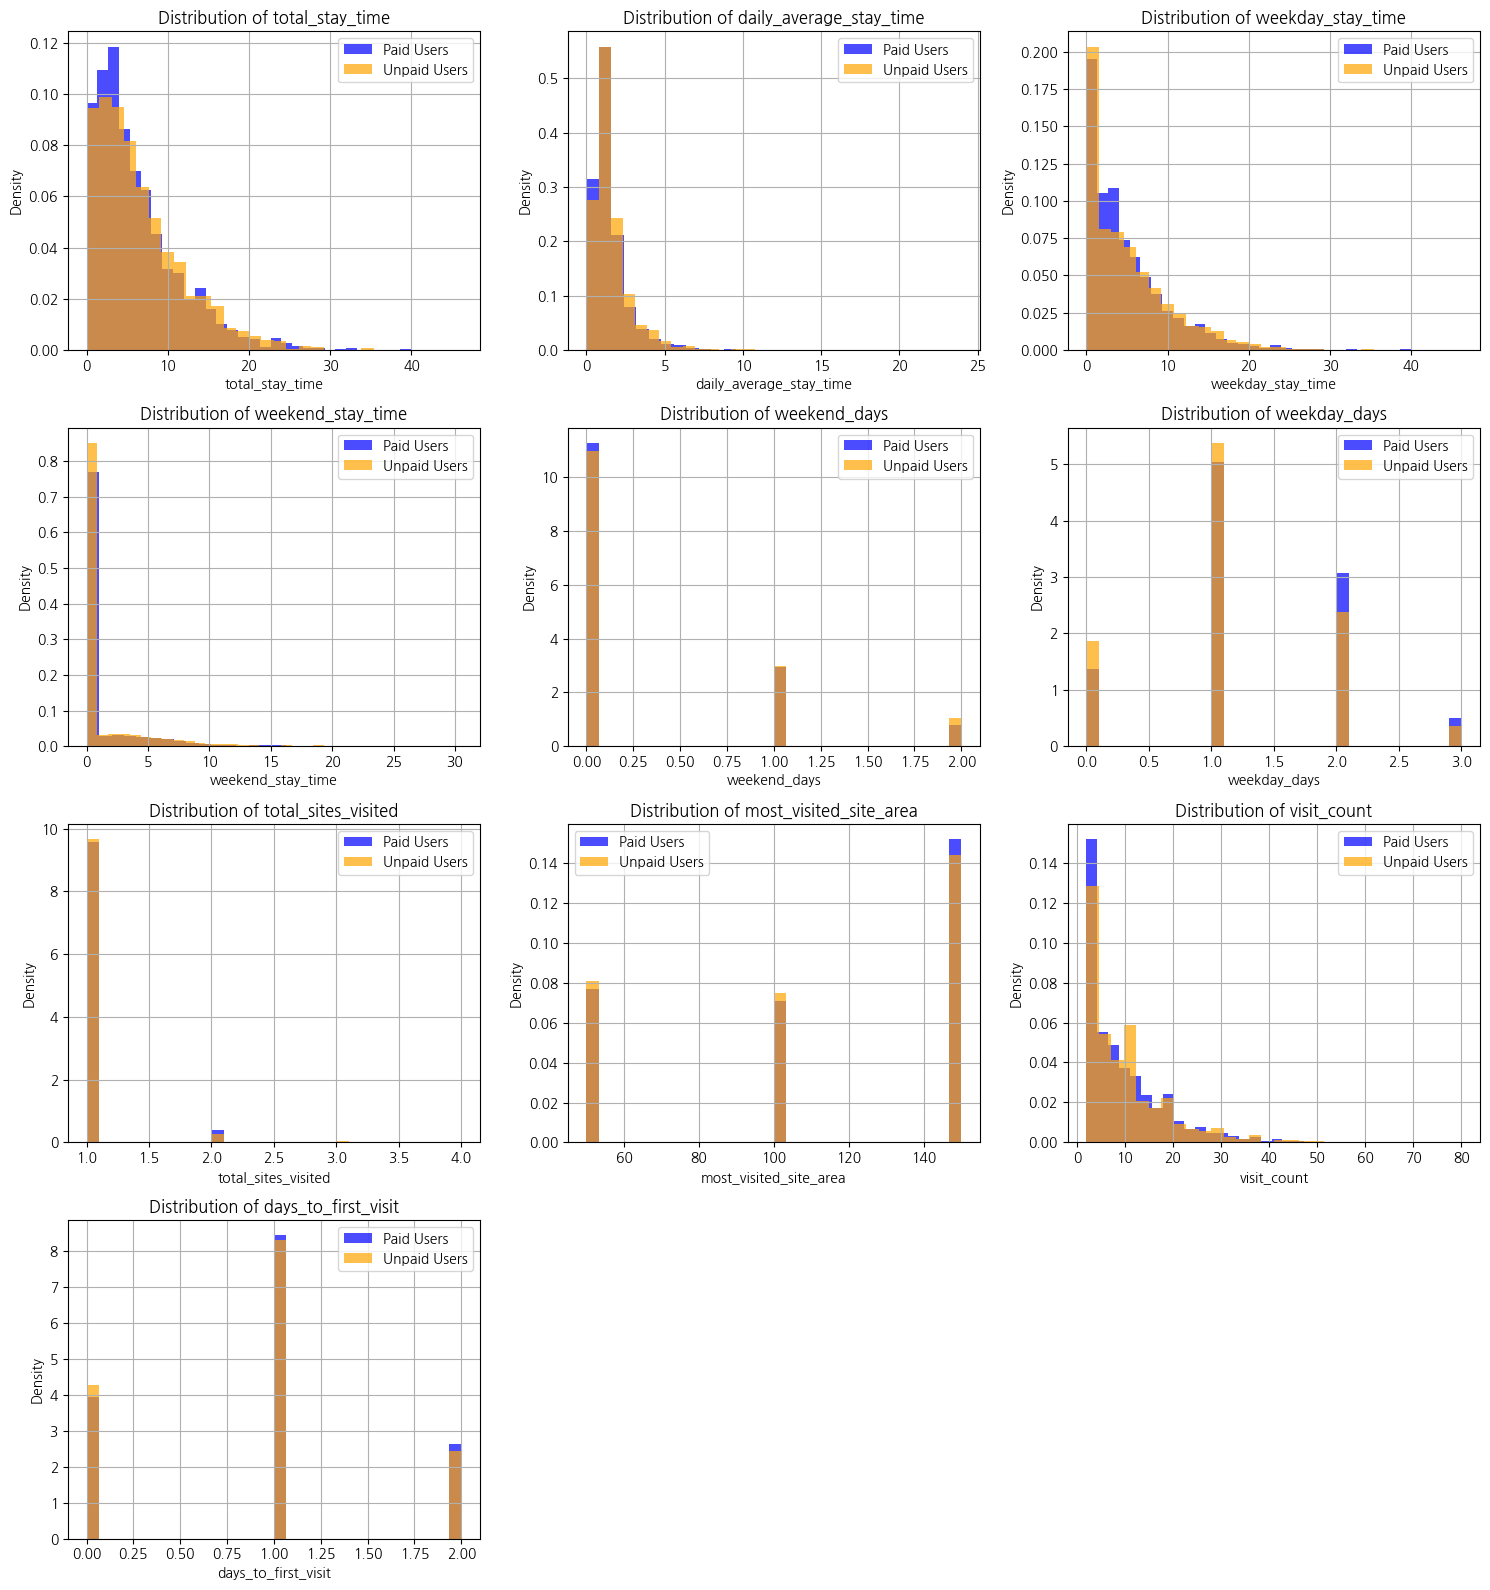

In [45]:
# 결제 상태를 기준으로 데이터를 분리
paid_users = final_merged_data[final_merged_data['is_payment'] == 1]
unpaid_users = final_merged_data[final_merged_data['is_payment'] == 0]

# 통계적으로 유의미한지 테스트할 특징 목록
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 각 특징에 대해 t-검정 수행
significance_results = []
for feature in features:
    if feature in final_merged_data.columns:
        stat, p_value = ttest_ind(paid_users[feature], unpaid_users[feature], equal_var=False, nan_policy='omit')
        significance_results.append((feature, stat, p_value))

# 결과 표시
significance_df = pd.DataFrame(significance_results, columns=['Feature', 'T-Statistic', 'P-Value'])
print(significance_df)

# 서브플롯의 행과 열 수 계산
num_features = len(features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# 시각화를 위한 서브플롯 생성
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(paid_users[feature], bins=30, alpha=0.7, label='Paid Users', density=True, color='blue')
    ax.hist(unpaid_users[feature], bins=30, alpha=0.7, label='Unpaid Users', density=True, color='orange')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

# 사용되지 않은 서브플롯 비활성화
for j in range(num_features, len(axes)):
    axes[j].axis('off')

# 레이아웃 조정
plt.tight_layout()
plt.show()

결제 여부에 따라 유저들의 행동 데이터 분포에 뚜렷한 차이가 없음.

                   Feature  Pearson Correlation  Pearson P-Value  \
0          total_stay_time            -0.045793     3.767182e-04   
1  daily_average_stay_time             0.001375     9.150075e-01   
2        weekday_stay_time            -0.010566     4.121888e-01   
3        weekend_stay_time            -0.058813     4.912776e-06   
4             weekend_days            -0.064921     4.561124e-07   
5             weekday_days            -0.001447     9.105909e-01   
6      total_sites_visited            -0.028529     2.678369e-02   
7   most_visited_site_area             0.069358     7.067907e-08   
8              visit_count            -0.033200     9.953524e-03   
9      days_to_first_visit             0.129262     7.166221e-24   

   Spearman Correlation  Spearman P-Value  
0             -0.031220      1.536767e-02  
1             -0.001866      8.848761e-01  
2             -0.000028      9.982753e-01  
3             -0.046180      3.357567e-04  
4             -0.047276      2.

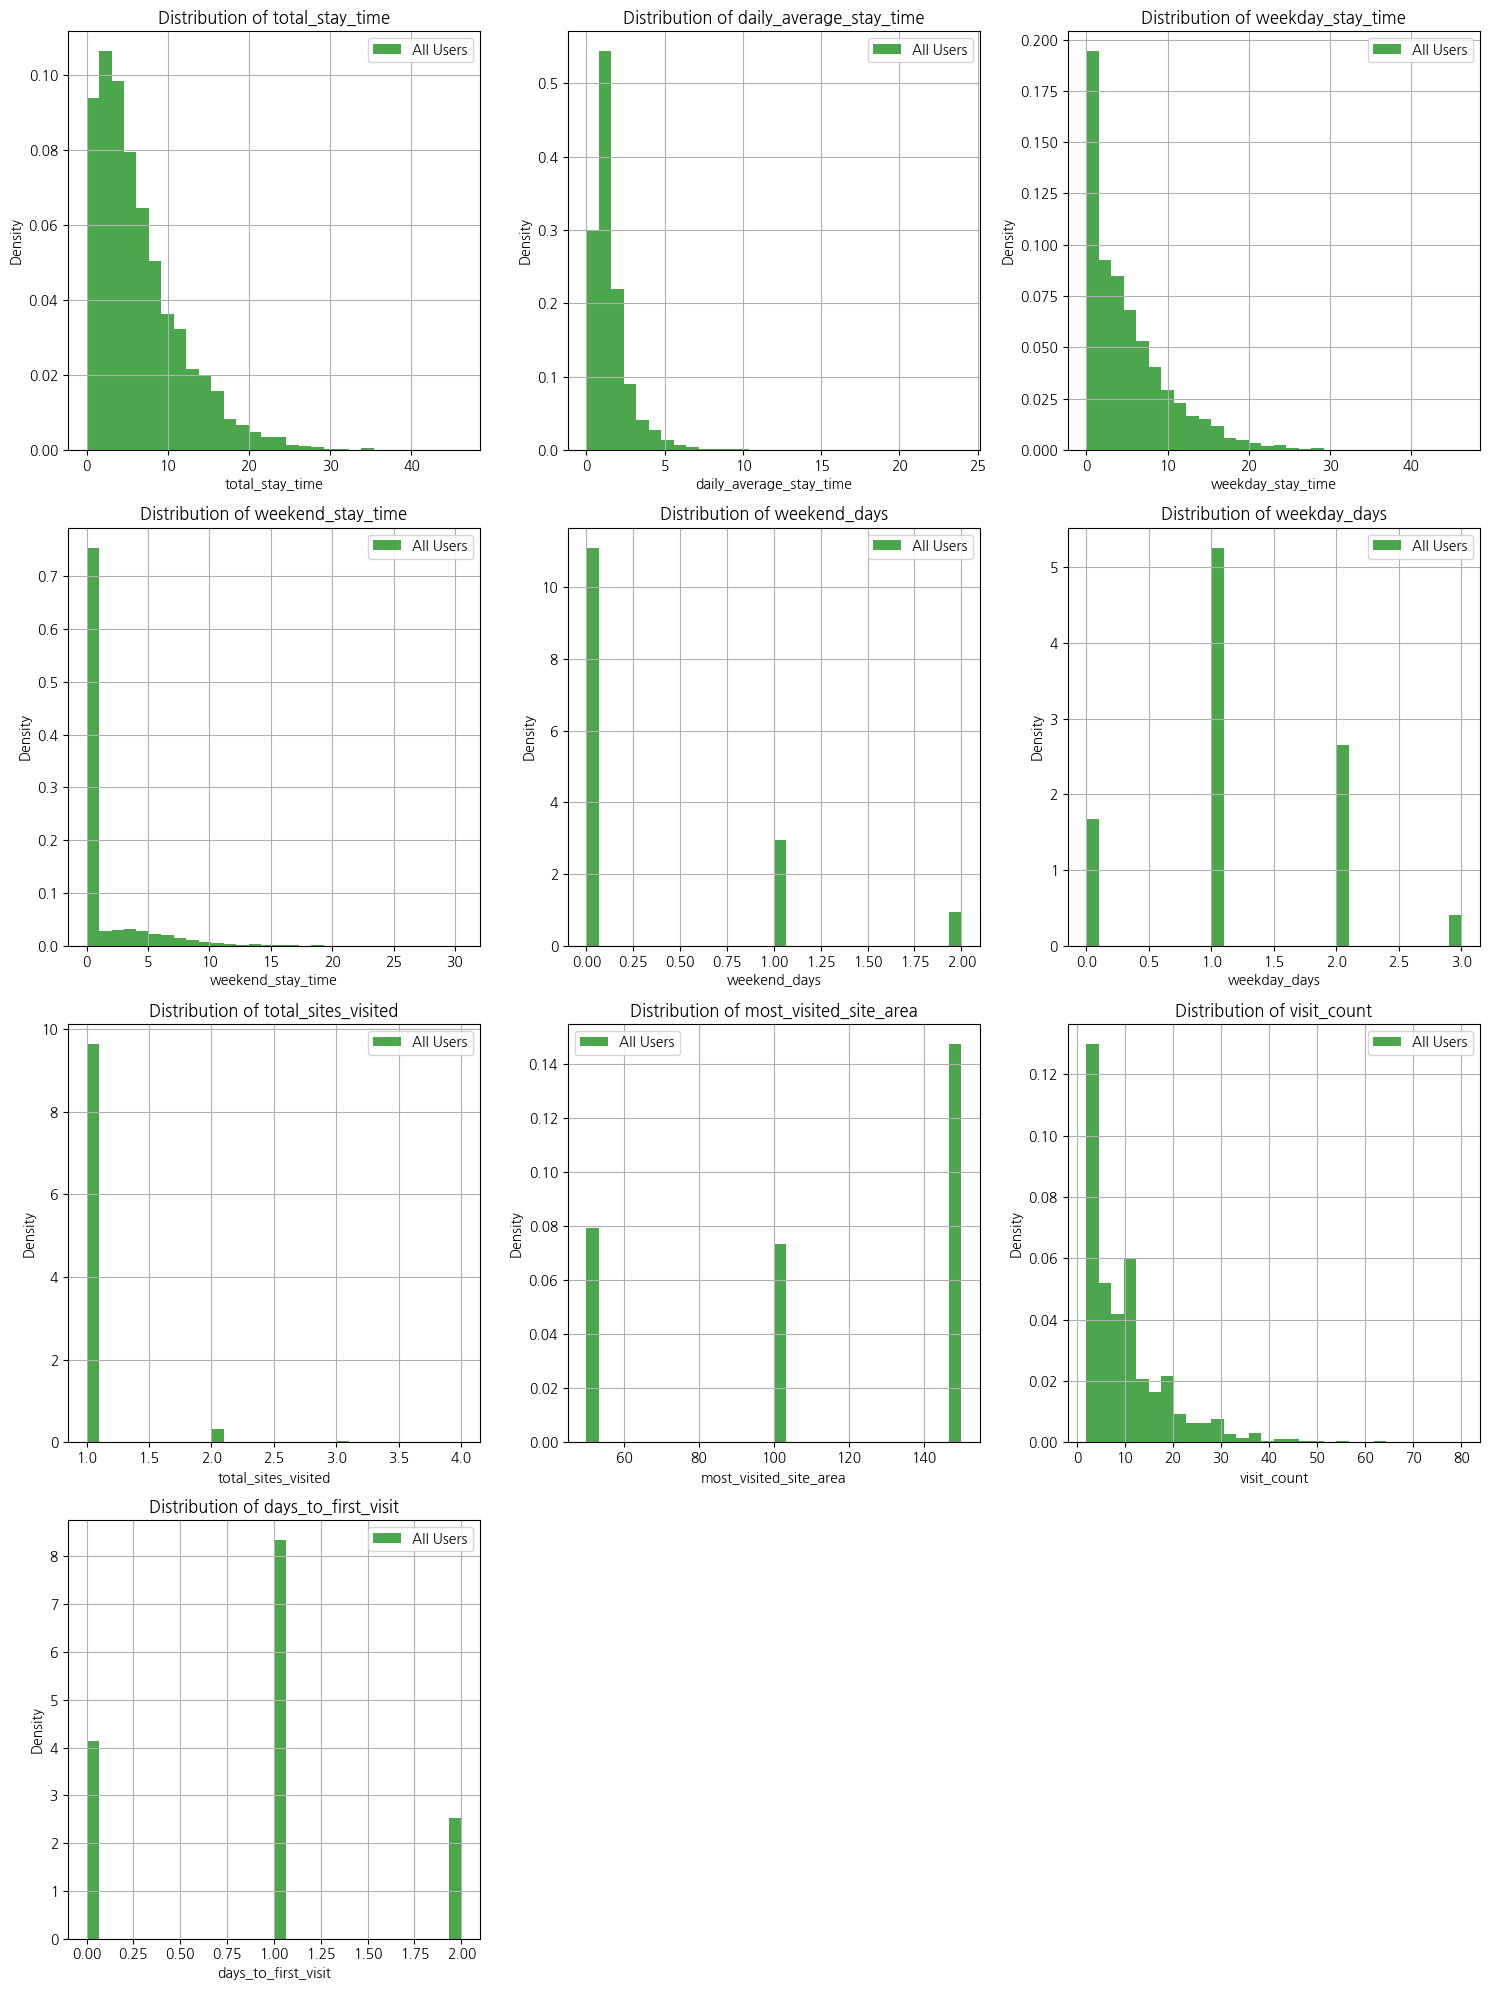

In [59]:
grouped_data = final_merged_data.groupby('trial_date_month')  # 'trial_date_month'를 실제 그룹화 기준 열로 대체
grouped_data = grouped_data['is_payment'].mean().reset_index()
grouped_data.rename(columns={'is_payment': 'payment_rate'}, inplace=True)

# 원본 데이터에 결제 비율 다시 병합
final_merged_data = final_merged_data.merge(grouped_data, on='trial_date_month', how='left')

# 분석할 특징 목록
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 결제 비율과의 피어슨 및 스피어만 상관계수 계산
correlation_results = []
for feature in features:
    if feature in final_merged_data.columns:
        pearson_corr, pearson_p = pearsonr(final_merged_data['payment_rate'], final_merged_data[feature])
        spearman_corr, spearman_p = spearmanr(final_merged_data['payment_rate'], final_merged_data[feature])
        correlation_results.append((feature, pearson_corr, pearson_p, spearman_corr, spearman_p))

# 결과를 표시하기 위한 데이터프레임 생성
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Pearson Correlation', 'Pearson P-Value', 'Spearman Correlation', 'Spearman P-Value'])
print(correlation_df)

# 서브플롯의 행과 열 수 계산
num_features = len(features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# 시각화를 위한 서브플롯 생성
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(final_merged_data[feature], bins=30, alpha=0.7, label='All Users', density=True, color='green')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

# 사용되지 않은 서브플롯 비활성화
for j in range(num_features, len(axes)):
    axes[j].axis('off')

# 레이아웃 조정
plt.tight_layout()
plt.show()

결제전환율에 유의미한 영향을 주는 독립변수 없음

종합적인 EDA 평가: 결제 전환에 유의미한 영향을 주는 변수가 파악 되지 않기 때문에 머신러닝으로 모델링을 하더라도 충분한 성능이 나오지 않을 것으로 보임

#모델링 START!

##로지스틱 회귀분석

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.08858667904100823}
Best AUC Score: 0.606572974726952
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76      1107
           1       0.60      0.15      0.24       701

    accuracy                           0.63      1808
   macro avg       0.62      0.54      0.50      1808
weighted avg       0.62      0.63      0.56      1808

Confusion Matrix:
[[1036   71]
 [ 595  106]]


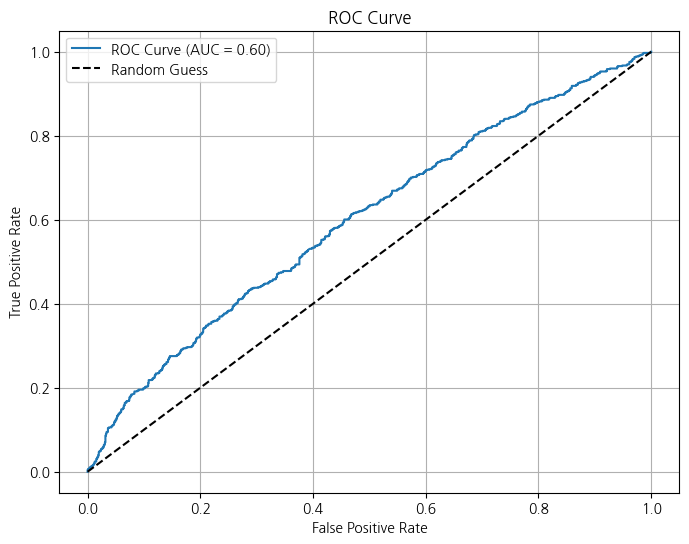

Feature Importances:
                   Feature  Importance
5             weekday_days    0.779372
4             weekend_days    0.377523
9      days_to_first_visit    0.198165
1  daily_average_stay_time    0.036226
8              visit_count    0.008361
3        weekend_stay_time    0.001753
7   most_visited_site_area    0.000641
0          total_stay_time   -0.045022
2        weekday_stay_time   -0.046775
6      total_sites_visited   -0.181433


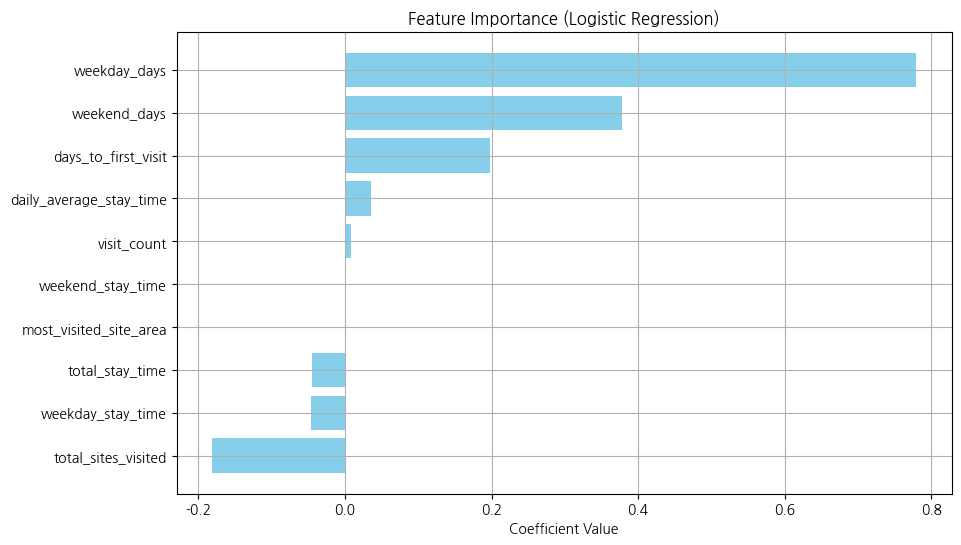

In [47]:
# 로지스틱 회귀를 위한 주요 변수 선택
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 선택한 변수와 타깃(is_payment)에 결측치가 있는 행 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 로지스틱 회귀 모델 초기화
model = LogisticRegression(random_state=42, solver='saga', max_iter=1000)

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # 규제 유형
    'C': np.logspace(-4, 4, 20),  # 규제 강도
    'l1_ratio': np.linspace(0, 1, 10)  # elasticnet 사용 시 l1 비율
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,  # 탐색 횟수
    scoring='roc_auc',  # 평가 지표: AUC
    cv=5,  # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 설명력(회귀 계수) 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.coef_[0]
}).sort_values(by='Importance', ascending=False)

print("Coefficients:")
print(feature_importance)

# 설명력 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Coefficients (Logistic Regression)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

##랜덤포레스트

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best AUC Score: 0.5920435389023517
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.85      0.73      1107
           1       0.48      0.22      0.30       701

    accuracy                           0.61      1808
   macro avg       0.56      0.54      0.51      1808
weighted avg       0.57      0.61      0.56      1808

Confusion Matrix:
[[942 165]
 [547 154]]


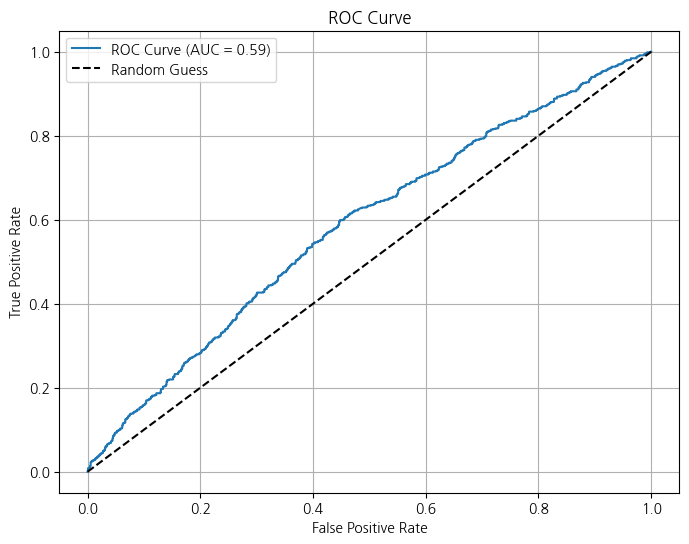

R^2 Score: -0.6589
Feature Importances:
                   Feature  Importance
1  daily_average_stay_time    0.304578
2        weekday_stay_time    0.223999
0          total_stay_time    0.194820
3        weekend_stay_time    0.062525
8              visit_count    0.061430
7   most_visited_site_area    0.045247
9      days_to_first_visit    0.043676
5             weekday_days    0.041518
6      total_sites_visited    0.014893
4             weekend_days    0.007315


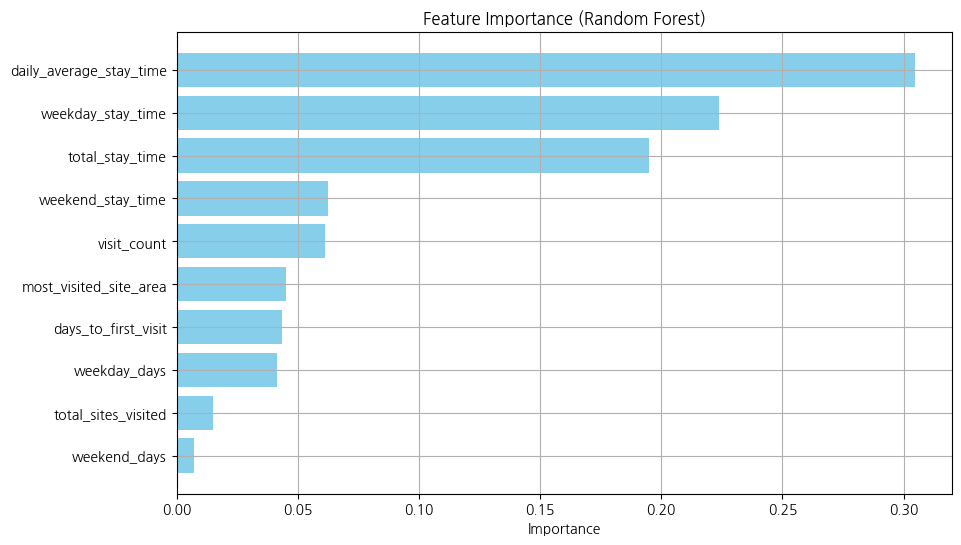

In [99]:
# 랜덤 포레스트를 위한 주요 변수 선택
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 선택한 변수와 타깃(is_payment)에 결측치가 있는 행 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 랜덤 포레스트 모델 초기화
model = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(50, 500, 10)],  # 트리 개수
    'max_features': ['sqrt', 'log2', None],  # 최적화할 특성 개수
    'max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None],  # 트리 최대 깊이
    'min_samples_split': [2, 5, 10],  # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],  # 리프 노드 최소 샘플 수
    'bootstrap': [True, False]  # 부트스트랩 샘플링 사용 여부
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,  # 탐색 횟수
    scoring='roc_auc',  # 평가 지표: AUC
    cv=5,  # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 계산 및 출력
r2 = r2_score(y_test, y_pred_proba.round())
print(f"R^2 Score: {r2:.4f}")

# 변수 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

##LGBM

[LightGBM] [Info] Number of positive: 1636, number of negative: 2582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 4218, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387862 -> initscore=-0.456310
[LightGBM] [Info] Start training from score -0.456310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

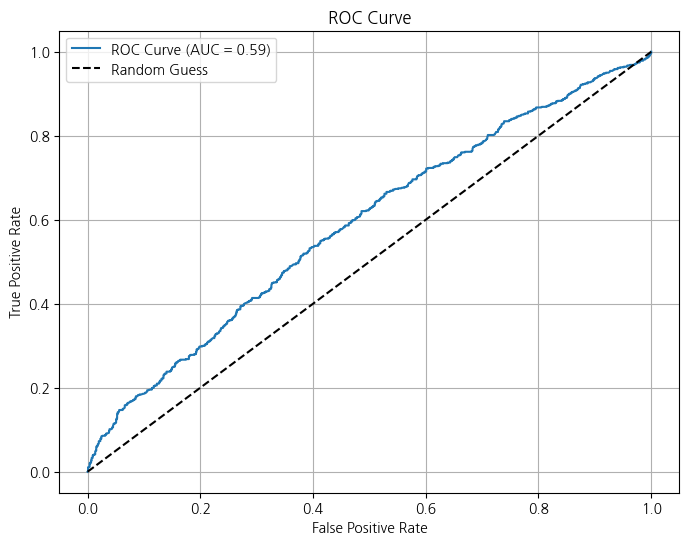

R^2 Score: -0.5727
Feature Importances:
                   Feature  Importance
1  daily_average_stay_time         959
0          total_stay_time         637
2        weekday_stay_time         626
7   most_visited_site_area         259
9      days_to_first_visit         177
3        weekend_stay_time         152
5             weekday_days         134
8              visit_count         127
4             weekend_days           6
6      total_sites_visited           0


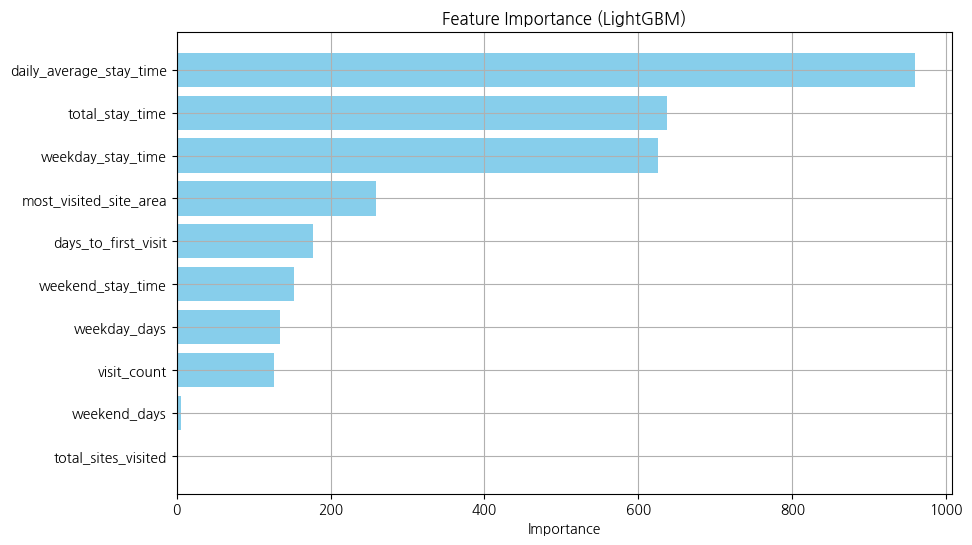

In [100]:
# LGBM을 위한 주요 변수 선택
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 선택한 변수와 타깃(is_payment)에 결측치가 있는 행 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# LGBM 모델 초기화
model = lgb.LGBMClassifier(random_state=42)

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'num_leaves': [31, 50, 100],  # 리프 노드 개수
    'max_depth': [-1, 10, 20, 30],  # 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'n_estimators': [100, 200, 500, 1000],  # 트리 개수
    'min_child_samples': [20, 50, 100],  # 리프 노드의 최소 데이터 수
    'subsample': [0.6, 0.8, 1.0],  # 부트스트랩 샘플링 비율
    'colsample_bytree': [0.6, 0.8, 1.0]  # 트리별 특성 샘플링 비율
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,  # 탐색 횟수
    scoring='roc_auc',  # 평가 지표: AUC
    cv=5,  # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 계산 및 출력
r2 = r2_score(y_test, y_pred_proba.round())
print(f"R^2 Score: {r2:.4f}")

# 변수 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

##Catboost

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'learning_rate': 0.01, 'l2_leaf_reg': 9, 'iterations': 500, 'depth': 4, 'border_count': 64}
Best AUC Score: 0.6075624335389926
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.96      0.76      1107
           1       0.62      0.11      0.19       701

    accuracy                           0.63      1808
   macro avg       0.63      0.53      0.47      1808
weighted avg       0.63      0.63      0.54      1808

Confusion Matrix:
[[1060   47]
 [ 623   78]]


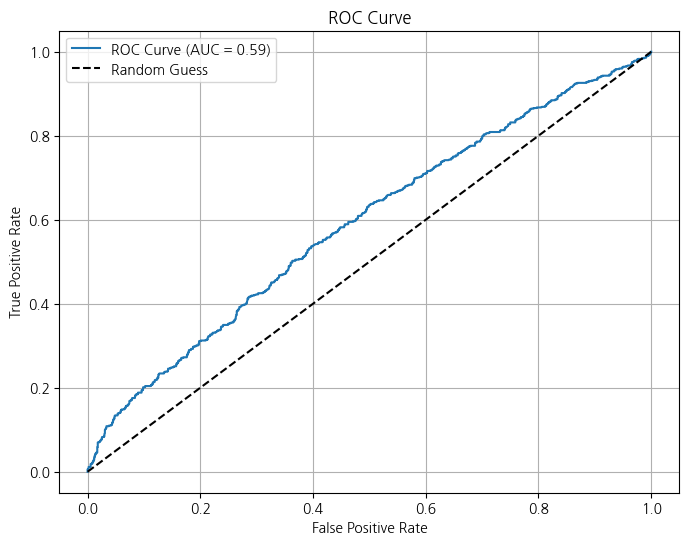

R^2 Score: -0.5610
Feature Importances:
                   Feature  Importance
5             weekday_days   26.736318
2        weekday_stay_time   20.286933
0          total_stay_time   14.006786
9      days_to_first_visit   10.158350
1  daily_average_stay_time    9.247861
4             weekend_days    4.861904
7   most_visited_site_area    4.742490
3        weekend_stay_time    4.548599
8              visit_count    3.627666
6      total_sites_visited    1.783092


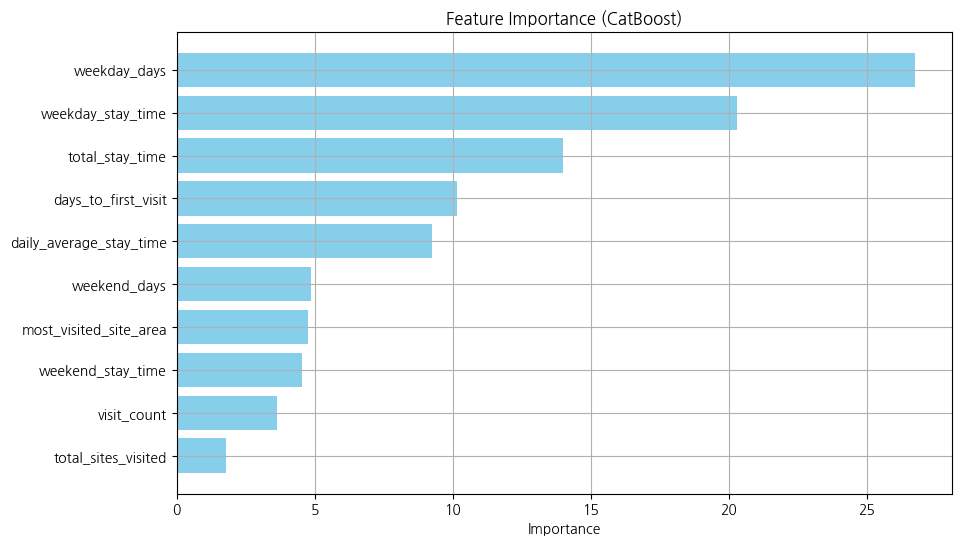

In [101]:
# CatBoost를 위한 주요 변수 선택
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 선택한 변수와 타깃(is_payment)에 결측치가 있는 행 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# CatBoost 모델 초기화
model = cb.CatBoostClassifier(random_state=42, verbose=0)

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'iterations': [100, 200, 500, 1000],  # 학습 반복 수
    'depth': [4, 6, 8, 10],  # 트리 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 정규화 계수
    'border_count': [32, 64, 128],  # 구간 개수
    'subsample': [0.6, 0.8, 1.0]  # 샘플링 비율
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,  # 탐색 횟수
    scoring='roc_auc',  # 평가 지표: AUC
    cv=5,  # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 계산 및 출력
r2 = r2_score(y_test, y_pred_proba.round())
print(f"R^2 Score: {r2:.4f}")

# 변수 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (CatBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

###SMOTE + ENN Catboost

Original target distribution:
is_payment
0    2582
1    1636
Name: count, dtype: int64
Resampled target distribution:
is_payment
1    763
0    686
Name: count, dtype: int64
Best Parameters: {'subsample': 0.6, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 1000, 'depth': 10, 'border_count': 64}
Best AUC Score: 0.9654753155500619
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1107
           1       0.42      0.50      0.46       701

    accuracy                           0.54      1808
   macro avg       0.53      0.53      0.53      1808
weighted avg       0.56      0.54      0.55      1808

Confusion Matrix:
[[630 477]
 [351 350]]


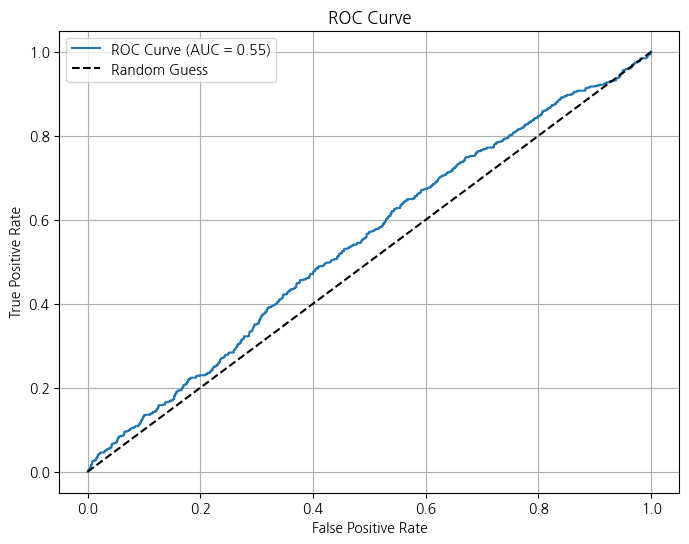

R^2 Score: -0.9291
Feature Importances:
                   Feature  Importance
1  daily_average_stay_time   17.640150
7   most_visited_site_area   14.989287
0          total_stay_time   13.981255
8              visit_count   13.864075
2        weekday_stay_time   13.696175
9      days_to_first_visit   11.591673
5             weekday_days    8.728101
3        weekend_stay_time    3.864692
4             weekend_days    1.379255
6      total_sites_visited    0.265337


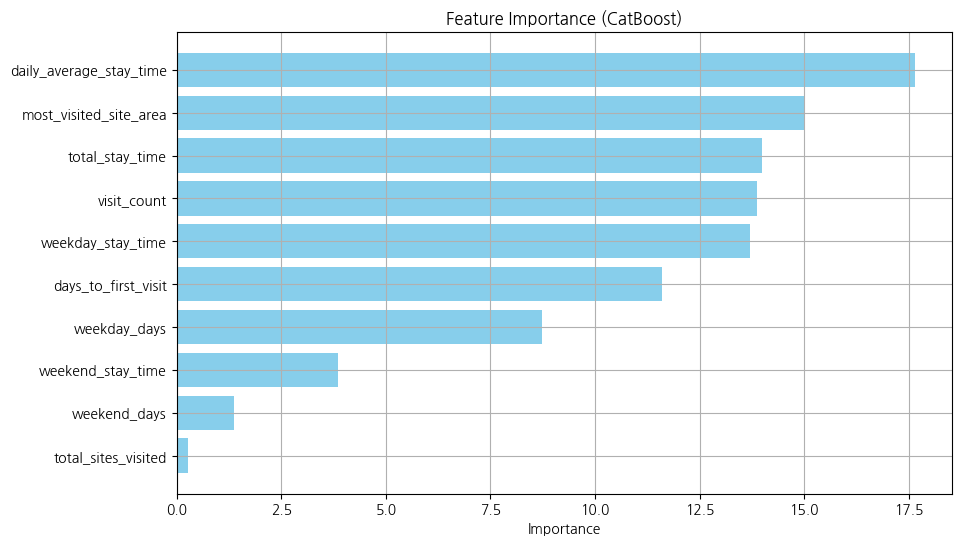

In [40]:
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import catboost as cb
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 결측치 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# SMOTE + ENN 적용
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(f"Original target distribution:\n{y_train.value_counts()}")
print(f"Resampled target distribution:\n{pd.Series(y_train_resampled).value_counts()}")

# CatBoost 모델 초기화
model = cb.CatBoostClassifier(random_state=42, verbose=0)

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'iterations': [100, 200, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'subsample': [0.6, 0.8, 1.0]
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# 랜덤 서치 실행
random_search.fit(X_train_resampled, y_train_resampled)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 계산 및 출력
r2 = r2_score(y_test, y_pred_proba.round())
print(f"R^2 Score: {r2:.4f}")

# 변수 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (CatBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

- smote+enn을 이용한 데이터 증 후 train 데이터의 교차 검증 best-auc socre는 0.97로 높은 성능을 보였지만, test 데이터에서의 AUC score는 0.55, 정확도는 0.54로 랜덤 분류 수준의 예측 성능을 보임. test 데이터에서의 성능 저조는 일반화가 어려움을 시사함

##XGboost

Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best AUC Score: 0.5990821776620544
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.95      0.76      1107
           1       0.61      0.13      0.22       701

    accuracy                           0.63      1808
   macro avg       0.62      0.54      0.49      1808
weighted avg       0.62      0.63      0.55      1808

Confusion Matrix:
[[1047   60]
 [ 609   92]]


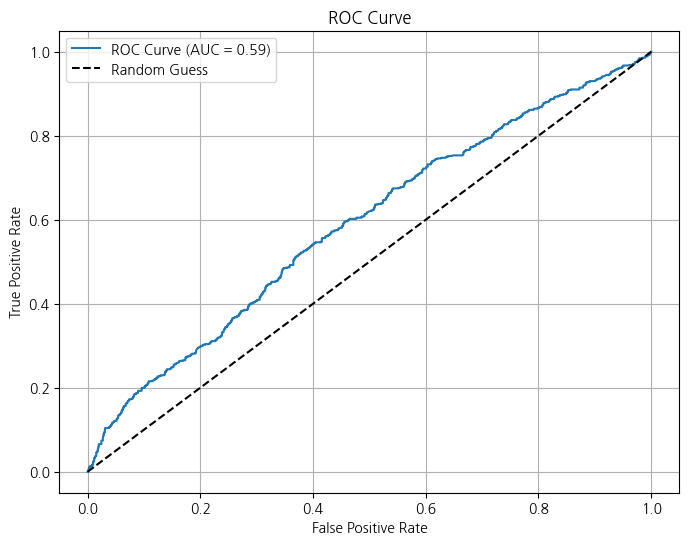

R^2 Score: -0.5587
Feature Importances:
                   Feature  Importance
5             weekday_days    0.149288
2        weekday_stay_time    0.139403
0          total_stay_time    0.109653
9      days_to_first_visit    0.105630
4             weekend_days    0.103990
1  daily_average_stay_time    0.093628
3        weekend_stay_time    0.092156
8              visit_count    0.071741
6      total_sites_visited    0.070014
7   most_visited_site_area    0.064496


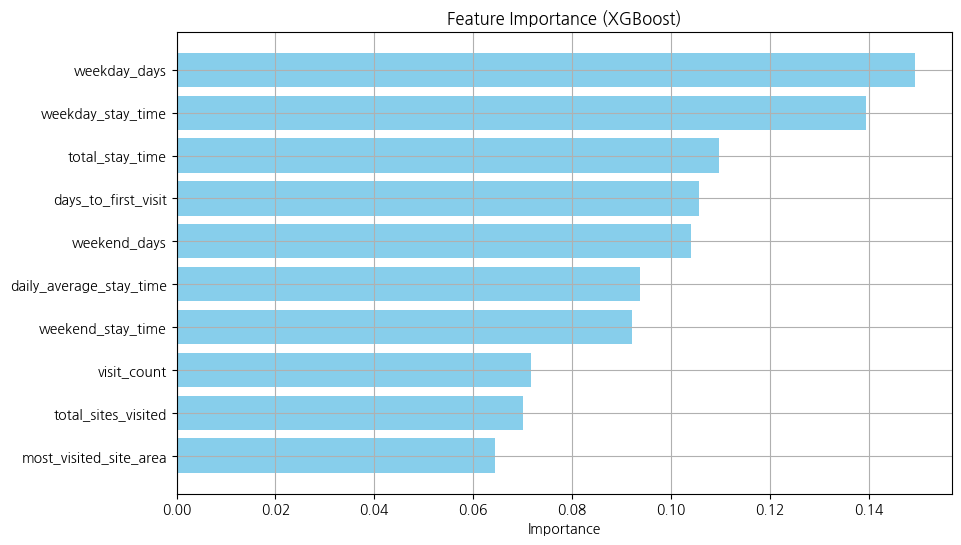

In [102]:
# XGBoost를 위한 주요 변수 선택
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 선택한 변수와 타깃(is_payment)에 결측치가 있는 행 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# XGBoost 모델 초기화
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],  # 트리 개수
    'max_depth': [3, 6, 10, 15],  # 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'subsample': [0.6, 0.8, 1.0],  # 부트스트랩 샘플링 비율
    'colsample_bytree': [0.6, 0.8, 1.0],  # 트리별 특성 샘플링 비율
    'min_child_weight': [1, 3, 5, 7],  # 최소 가중치 합
    'gamma': [0, 0.1, 0.2, 0.5]  # 분할을 위한 최소 손실 감소
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,  # 탐색 횟수
    scoring='roc_auc',  # 평가 지표: AUC
    cv=5,  # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 계산 및 출력
r2 = r2_score(y_test, y_pred_proba.round())
print(f"R^2 Score: {r2:.4f}")

# 변수 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

###SMOTE + ENN XGboost

Original target distribution:
is_payment
0    2582
1    1636
Name: count, dtype: int64
Resampled target distribution:
is_payment
1    763
0    686
Name: count, dtype: int64
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best AUC Score: 0.9369002087018531
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1107
           1       0.43      0.49      0.46       701

    accuracy                           0.55      1808
   macro avg       0.54      0.54      0.53      1808
weighted avg       0.56      0.55      0.55      1808

Confusion Matrix:
[[646 461]
 [358 343]]


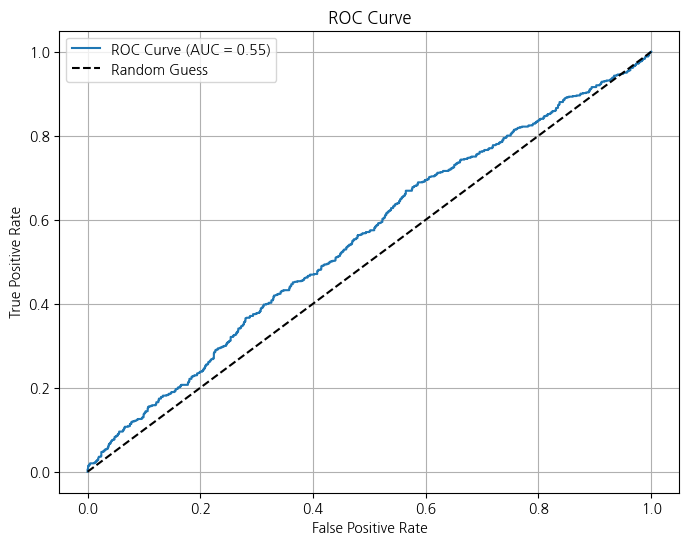

R^2 Score: -0.9082
Feature Importances:
                   Feature  Importance
5             weekday_days    0.167067
4             weekend_days    0.120444
9      days_to_first_visit    0.108197
2        weekday_stay_time    0.104659
8              visit_count    0.095822
7   most_visited_site_area    0.094676
0          total_stay_time    0.088978
3        weekend_stay_time    0.084189
1  daily_average_stay_time    0.074326
6      total_sites_visited    0.061642


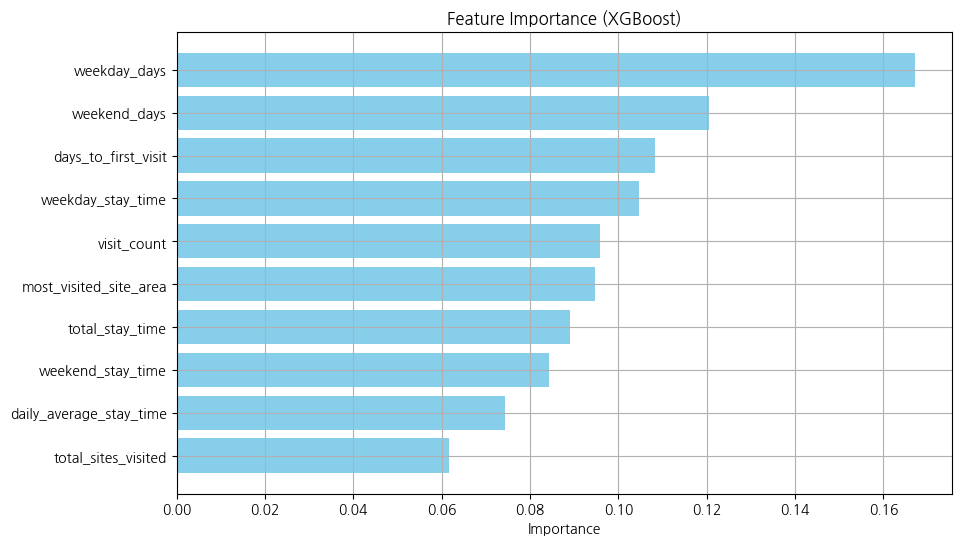

In [39]:
# 주요 변수 선택
features = ['total_stay_time', 'daily_average_stay_time', 'weekday_stay_time', 'weekend_stay_time',
            'weekend_days', 'weekday_days', 'total_sites_visited', 'most_visited_site_area',
            'visit_count', 'days_to_first_visit']

# 결측치 제거
final_merged_data = final_merged_data.dropna(subset=features + ['is_payment'])

# 독립 변수(X)와 종속 변수(y) 정의
X = final_merged_data[features]
y = final_merged_data['is_payment']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# SMOTE + ENN 적용
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(f"Original target distribution:\n{y_train.value_counts()}")
print(f"Resampled target distribution:\n{pd.Series(y_train_resampled).value_counts()}")

# XGBoost 모델 초기화
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 하이퍼파라미터 랜덤 서치를 위한 파라미터 범위 정의
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# 랜덤 서치 실행
random_search.fit(X_train_resampled, y_train_resampled)

# 최적의 모델과 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 분류 보고서와 혼동 행렬 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC 곡선 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 계산 및 출력
r2 = r2_score(y_test, y_pred_proba.round())
print(f"R^2 Score: {r2:.4f}")

# 변수 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

- smote+enn을 통한 train 데이터 증강 후, train 데이터의 교차 검증 best-auc socre는 0.94로 높은 성능을 보였지만 test 데이터에서의 성능은 0.55로 랜덤 분류 수준의 예측 성능을 보임. test 데이터에서의 성능 저조는 일반화가 어려움을 시사함
- 데이터 증강 후 성능이 오히려 떨어짐


동일한 데이터와 feature들을 이용해 로지스틱 회귀 모델, 랜덤포레스트, LGBM, Catboost, XGboost로 모델링 하고 각 유저의 결제 여부를 예측함

최고 모델 성능(Catboost):

AUC 점수: 0.6076

정확도(Accuracy): 63%

R² 점수: -0.5610 (설명력 부족)

분류 보고서 및 혼동 행렬:

클래스 1(결제 사용자)의 재현율(Recall): 11%로 매우 낮음.

F1-점수는 클래스 1에서 0.19로, 불균형 데이터의 영향을 크게 받음.

혼동 행렬에서 미결제 사용자(클래스 0)를 잘 예측했으나, 결제 사용자(클래스 1) 예측에는 한계가 있음.



In [56]:
from flask import Flask, render_template, request, jsonify
import pandas as pd
import matplotlib.pyplot as plt
import os

# Flask 앱 초기화
app = Flask(__name__)

# 한글 설정
plt.rc('font', family='Malgun Gothic')  # matplotlib 한글 지원

# 메인 페이지 - 요약 대시보드
@app.route('/')
def dashboard():
    total_users = final_merged_data['user_uuid'].nunique()
    total_visits = final_merged_data['visit_count'].sum()
    avg_daily_stay = final_merged_data['daily_average_stay_time'].mean()
    total_sites = final_merged_data['total_sites_visited'].sum()

    return render_template('dashboard.html',
                           total_users=total_users,
                           total_visits=total_visits,
                           avg_daily_stay=avg_daily_stay,
                           total_sites=total_sites)

# 날짜별 데이터 보기
@app.route('/date-report')
def date_report():
    grouped = final_merged_data.groupby('trial_date').agg({
        'user_uuid': 'nunique',
        'visit_count': 'sum',
        'daily_average_stay_time': 'mean'
    }).reset_index()

    grouped.rename(columns={
        'trial_date': '날짜',
        'user_uuid': '유저 수',
        'visit_count': '방문 횟수',
        'daily_average_stay_time': '평균 재실 시간'
    }, inplace=True)

    return render_template('date_report.html', data=grouped.to_dict(orient='records'))

# 유저별 데이터 보기
@app.route('/user-report')
def user_report():
    user_id = request.args.get('user_id')
    if user_id:
        user_data = final_merged_data[final_merged_data['user_uuid'] == user_id]
        if not user_data.empty:
            user_summary = user_data.groupby('user_uuid').agg({
                'visit_count': 'sum',
                'total_stay_time': 'sum',
                'weekday_stay_time': 'sum',
                'weekend_stay_time': 'sum'
            }).reset_index()

            return render_template('user_report.html', user_data=user_data.to_dict(orient='records'),
                                   user_summary=user_summary.to_dict(orient='records')[0])

    return render_template('user_report.html', user_data=[], user_summary={})

# 데이터 검색 API
@app.route('/search', methods=['POST'])
def search():
    search_date = request.form.get('search_date')
    search_user = request.form.get('search_user')

    results = final_merged_data.copy()

    if search_date:
        results = results[results['trial_date'] == search_date]
    if search_user:
        results = results[results['user_uuid'] == search_user]

    return jsonify(results.to_dict(orient='records'))

# 플라스크 실행
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


ImportError: cannot import name 'EVENT_TYPE_OPENED' from 'watchdog.events' (C:\Users\che98\anaconda3\lib\site-packages\watchdog\events.py)